# EC500 - Group 6 - UNet-based Standard Deviation Noise Maps of CT Images 
**Avantika Kothandaraman, Caiwei Zhang, Long Chen**

## Section-1: Installing the necessary packages

In [2]:
!pip install pynrrd
!pip install SimpleITK
!python -c "import monai" || pip install -q "monai"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [132]:
!pip install monai --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [108]:
!pip install patchify

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
import torch.optim as optim
import os
import nibabel as nib
import nrrd
from torchvision.datasets import ImageFolder
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy import ndimage
import tempfile
import shutil
import glob

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    Activations,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureChannelFirst,
    Compose,
    AsChannelLastd,
    CropForegroundd,
    ScaleIntensityd,
    LoadImaged,
    Orientationd,
    Spacingd,
    Invertd,
    RandSpatialCropSamplesd,
    RandSpatialCropSamples,
    RandSpatialCropd,
    ScaleIntensityRanged,
    ScaleIntensityRange,
    RandRotated,
    RandFlipd,
    RandZoomd,
    RandScaleIntensityd, 
    RandShiftIntensityd,
    #AddChannel,
    ToTensord,
    NormalizeIntensityd
)
from monai.handlers.utils import from_engine 
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference 
from monai.inferers import SlidingWindowInferer
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, pad_list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
from patchify import patchify
import monai.transforms as mTransforms
import math
import torch.nn.functional as F


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [3]:
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [4]:
import gc

gc.collect()

torch.cuda.empty_cache()

## Section-2: Initial data inspection and experimentation

In [5]:
# initializing directory
data_dir = "/projectnb/ec500kb/projects/Project6/scans"

In [5]:
# looping through for inspection
count = 0
dims = []
sizes = []
shapes = []

for filename in os.listdir(data_dir):
    if filename.endswith('.nrrd'):
        count += 1
        img, header = nrrd.read(os.path.join(data_dir,filename))
        dims.append(img.ndim)
        sizes.append(img.size)
        shapes.append(img.shape)
        
dims_check = all(dim == dims[0] for dim in dims)
size_check = all(size == sizes[0] for size in sizes)
shape_check = all(shape == shapes[0] for shape in shapes)

if dims_check and size_check and shape_check:
    print('Dimensions, shapes and sizes are uniform')
else:
    print('Dimensions, shapes and sizes are NOT uniform')
    
print('The total number of images in the dataset is {}'.format(count))

Dimensions, shapes and sizes are NOT uniform
The total number of images in the dataset is 30


In [6]:
list(shapes)

[(512, 512, 318),
 (512, 512, 318),
 (512, 512, 823),
 (512, 512, 526),
 (512, 512, 610),
 (512, 512, 823),
 (512, 512, 600),
 (512, 512, 525),
 (512, 512, 560),
 (512, 512, 856),
 (512, 512, 560),
 (512, 512, 610),
 (512, 512, 600),
 (512, 512, 610),
 (512, 512, 585),
 (512, 512, 318),
 (512, 512, 525),
 (512, 512, 526),
 (512, 512, 526),
 (512, 512, 823),
 (512, 512, 525),
 (512, 512, 600),
 (512, 512, 856),
 (512, 512, 533),
 (512, 512, 585),
 (512, 512, 533),
 (512, 512, 560),
 (512, 512, 533),
 (512, 512, 585),
 (512, 512, 856)]

In [48]:
def convert_to_2d(img_volume, axis=1):
    return np.max(img_volume, axis=axis)

trans = transforms.Compose([
    transforms.ToTensor()
    #transforms.Resize((512,512)),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

In [49]:
volume, header = nrrd.read(os.path.join(data_dir,'L506_signal.nrrd'))
volume_2d = convert_to_2d(volume)
#volume_2d = trans(volume_2d)
print(volume.shape, volume_2d.squeeze().shape, volume_2d.dtype)

(512, 512, 526) (512, 526) int16


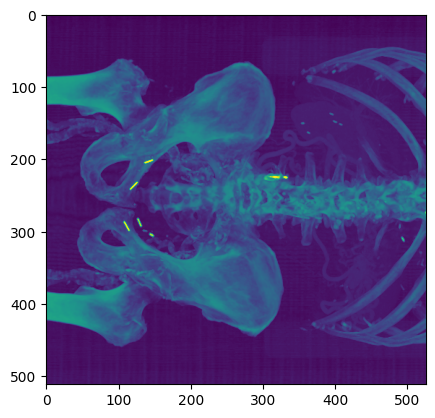

In [50]:
plt.imshow(volume_2d.squeeze())
plt.show()

In [9]:
volume_2d = volume_2d.numpy()
volume_2d.dtype

dtype('int16')

In [6]:
def patches(image):
    demo_dict = []
    image = image.squeeze()
    patches = patchify(image.numpy(), (64,64), step=64)
        
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            single_patch_img = patches[i,j,:,:]
            demo_dict.append(single_patch_img)
    return demo_dict

In [208]:
patch1 = patches(volume_2d)

In [209]:
len(patch1)

64

In [210]:
patch1[15].shape

(64, 64)

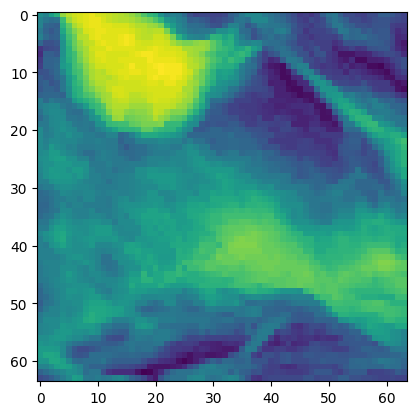

In [213]:
plt.imshow(patch1[20])

## Set deterministic seed for reproducibility

In [7]:
set_determinism(seed=0)

## Section-3: Creating a custom dataset and making transforms for augmentation


In [8]:
class CustomData(torch.utils.data.Dataset):

    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = []
        image_sizes = []
        
        for file in os.listdir(self.root_dir):
            if file.endswith('signal.nrrd'):
                image_id = file.split('_')[0]
                
                # reading in the images
                signal_nrrd, _ = nrrd.read(os.path.join(self.root_dir, file))
                noise_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_noise.nrrd"))
                std_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_std.nrrd"))

                # converting to 2D Axial and to tensors
                signal = np.max(signal_nrrd, axis=1)
                noise = np.max(noise_nrrd, axis=1)
                std = np.max(std_nrrd, axis=1)
                
                signal = torch.tensor(signal, dtype = torch.float32)
                noise = torch.tensor(noise, dtype = torch.float32)
                std = torch.tensor(std, dtype = torch.float32)

                # generating input image fromm signal and noise
                k = random.uniform(0,5)
                ct_generated = signal + (k*noise)
                
                # generating patches
                ct_patches = patches(ct_generated)
                std_patches = patches(std)
                print(ct_generated.shape, len(ct_patches), len(std_patches))
                
                # storing the new dataset in a dictionary
                for i in range(len(ct_patches)):
                    self.data.append({'ct_generated' : ct_patches[i], 'std_map' : std_patches[i]})
                
                
    def data_info(self, idx):
        item = self.data[idx]
        ct_gen = item['ct_generated']
        std_ma = item['std_map']

        # Print the index of the data item
        print(f"Data item {idx}:")

        # Print the shape of the ct_generated tensor
        print(f"ct_generated shape: {ct_gen.shape}")

        # Print the shape of the std_map tensor
        print(f"std_map shape: {std_ma.shape}")
        
        print(f"ct_generated dtype: {ct_gen.dtype}")
        print(f"std_map dtype: {ct_gen.dtype}")

        print()
            
            
    def plot_ct(self, idx):
        item = self.data[idx]
        ct_generated = item['ct_generated']
        std_map = item['std_map']
        
        # Create a figure
        plt.figure(figsize=(5,5))
        
        # Plot axial view of ct_generated
        plt.subplot(1, 2, 1)
        plt.imshow(ct_generated, cmap='gray')
        plt.title('ct_generated Patch-0')
        plt.axis('off')
        
        # Plot axial view of std_map
        plt.subplot(1, 2, 2)
        plt.imshow(std_map, cmap='hot')
        plt.title('std_map Patch-0')
        plt.axis('off')
        
        # Show the plots
        plt.show()

            
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        item = self.data[idx]
        return item

In [9]:
custom_dataset = CustomData(root_dir = data_dir)

torch.Size([512, 823]) 96 96
torch.Size([512, 526]) 64 64
torch.Size([512, 600]) 72 72
torch.Size([512, 525]) 64 64
torch.Size([512, 610]) 72 72
torch.Size([512, 318]) 32 32
torch.Size([512, 856]) 104 104
torch.Size([512, 533]) 64 64
torch.Size([512, 585]) 72 72
torch.Size([512, 560]) 64 64


In [10]:
len(custom_dataset)

704

In [14]:
custom_dataset.data_info(10)

Data item 10:
ct_generated shape: (64, 64)
std_map shape: (64, 64)
ct_generated dtype: float32
std_map dtype: float32



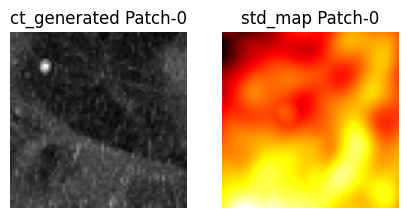

In [16]:
custom_dataset.plot_ct(12)

In [78]:
# transforms for data augmentation and refining

train_transforms = transforms.Compose([#ScaleIntensityd(keys = ['ct_generated', 'std_map']), 
                                       RandRotated(keys = ['ct_generated', 'std_map'], range_x=(-np.pi/12, np.pi/12), prob = 0.5, keep_size = True) 
                                       #RandFlipd(keys = ['ct_generated', 'std_map'], spatial_axis = 0, prob = 0.5), 
                                       #RandZoomd(keys = ['ct_generated', 'std_map'], zoom = (0.9,1.1), prob = 0.5) 
])

val_transforms = transforms.Compose([#ScaleIntensityd(keys = ['ct_generated', 'std_map']),
                                     RandRotated(keys = ['ct_generated', 'std_map'], range_x=(-np.pi/12, np.pi/12), prob = 0.5, keep_size = True)
                                     #RandFlipd(keys = ['ct_generated', 'std_map'], spatial_axis = 0, prob = 0.5, keep_size = True)
                                     #RandZoomd(keys = ['ct_generated', 'std_map'], zoom = (0.9,1.1), prob = 0.5, keep_size = True) 
])

## Section-4: Data Loader

In [11]:
train_dataset, val_dataset, test_dataset = custom_dataset[:568], custom_dataset[568:640], custom_dataset[640:]
#train_dataset, val_dataset, test_dataset = custom_dataset[:512], custom_dataset[512:576], custom_dataset[576:]
batch_size=1

#train_dataset, testval = train_test_split(custom_dataset, test_size=0.2, random_state=42)
#val_dataset, test_dataset = train_test_split(testval, test_size=0.5, random_state=42)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
print(len(train_loader), len(val_loader), len(test_loader))

568 72 64


In [12]:
# Function to print the size of DataLoader
def print_dataloader_sizes(loader, name):
    # Total number of samples
    total_samples = len(loader.dataset)
    
    # Number of batches
    num_batches = len(loader)
    
    # Assuming all batches have the same size except possibly the last one
    batch_size = loader.batch_size
    
    print(f'{name} DataLoader has:')
    print(f'  Total samples: {total_samples}')
    print(f'  Number of batches: {num_batches}')
    print(f'  Batch size: {batch_size}')
    if total_samples % batch_size != 0:
        print(f'  Last batch size: {total_samples % batch_size}')
    else:
        print(f'  All batches have the same size')

# Checking sizes for each DataLoader
print_dataloader_sizes(train_loader, 'Train')
print_dataloader_sizes(val_loader, 'Validation')
print_dataloader_sizes(test_loader, 'Test')


Train DataLoader has:
  Total samples: 568
  Number of batches: 568
  Batch size: 1
  All batches have the same size
Validation DataLoader has:
  Total samples: 72
  Number of batches: 72
  Batch size: 1
  All batches have the same size
Test DataLoader has:
  Total samples: 64
  Number of batches: 64
  Batch size: 1
  All batches have the same size


## Section-5: UNet Training and Testing

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels = None, dropout_rate=0.0):
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
            
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )
        
    def forward(self, x):
        return self.conv_op(x)
    
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, dropout_rate=0.0):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.dropout_rate = dropout_rate

        self.inc = (DoubleConv(n_channels, 64, dropout_rate=dropout_rate))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [15]:
# initializing the model and optimizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(n_channels = 1, n_classes = 1, dropout_rate=0.3).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
model_saving_path = '/projectnb/ec500kb/projects/Project6/'

In [17]:
# LOSS Function - Average Relative Error
def average_relative_error(output, target):
    absolute_error = torch.abs(output - target)
    nonzero_mask = target != 0  # Mask for non-zero elements in target
    return torch.mean(torch.abs((absolute_error[nonzero_mask] / target[nonzero_mask])))

In [17]:
# training and validation

train_losses = []
val_losses = []
num_epochs = 300

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        img = img.unsqueeze(0)
        std_map = images['std_map'].float().to(device)
        std_map = std_map.unsqueeze(0)
        #print(img.shape)
        #print(std_map.shape)
        optimizer.zero_grad()
        y_pred = model(img)
        #print(y_pred.shape)
        loss = average_relative_error(y_pred, std_map)
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            img = img.unsqueeze(0)
            std_map = image['std_map'].float().to(device)
            std_map = std_map.unsqueeze(0)

            y_pred = model(img)
            val_loss = average_relative_error(y_pred, std_map)
            #val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

100%|██████████| 72/72 [00:00<00:00, 305.78it/s]


Epoch [1/300], Train Loss: 0.9997, Validation Loss: 0.9995


100%|██████████| 72/72 [00:00<00:00, 307.74it/s]


Epoch [2/300], Train Loss: 0.9993, Validation Loss: 0.9988


100%|██████████| 72/72 [00:00<00:00, 307.28it/s]


Epoch [3/300], Train Loss: 0.9989, Validation Loss: 0.9988


100%|██████████| 72/72 [00:00<00:00, 307.41it/s]


Epoch [4/300], Train Loss: 0.9984, Validation Loss: 0.9979


100%|██████████| 72/72 [00:00<00:00, 307.17it/s]


Epoch [5/300], Train Loss: 0.9979, Validation Loss: 0.9971


100%|██████████| 72/72 [00:00<00:00, 307.53it/s]


Epoch [6/300], Train Loss: 0.9972, Validation Loss: 0.9968


100%|██████████| 72/72 [00:00<00:00, 307.80it/s]


Epoch [7/300], Train Loss: 0.9965, Validation Loss: 0.9952


100%|██████████| 72/72 [00:00<00:00, 306.96it/s]


Epoch [8/300], Train Loss: 0.9956, Validation Loss: 0.9956


100%|██████████| 72/72 [00:00<00:00, 307.97it/s]


Epoch [9/300], Train Loss: 0.9947, Validation Loss: 0.9946


100%|██████████| 72/72 [00:00<00:00, 308.08it/s]


Epoch [10/300], Train Loss: 0.9938, Validation Loss: 0.9915


100%|██████████| 72/72 [00:00<00:00, 307.85it/s]


Epoch [11/300], Train Loss: 0.9927, Validation Loss: 0.9889


100%|██████████| 72/72 [00:00<00:00, 308.00it/s]


Epoch [12/300], Train Loss: 0.9916, Validation Loss: 0.9907


100%|██████████| 72/72 [00:00<00:00, 307.40it/s]


Epoch [13/300], Train Loss: 0.9905, Validation Loss: 0.9883


100%|██████████| 72/72 [00:00<00:00, 308.40it/s]


Epoch [14/300], Train Loss: 0.9892, Validation Loss: 0.9898


100%|██████████| 72/72 [00:00<00:00, 308.31it/s]


Epoch [15/300], Train Loss: 0.9879, Validation Loss: 0.9882


100%|██████████| 72/72 [00:00<00:00, 307.98it/s]


Epoch [16/300], Train Loss: 0.9865, Validation Loss: 0.9879


100%|██████████| 72/72 [00:00<00:00, 307.71it/s]


Epoch [17/300], Train Loss: 0.9851, Validation Loss: 0.9834


100%|██████████| 72/72 [00:00<00:00, 308.32it/s]


Epoch [18/300], Train Loss: 0.9835, Validation Loss: 0.9835


100%|██████████| 72/72 [00:00<00:00, 308.19it/s]


Epoch [19/300], Train Loss: 0.9819, Validation Loss: 0.9798


100%|██████████| 72/72 [00:00<00:00, 308.13it/s]


Epoch [20/300], Train Loss: 0.9801, Validation Loss: 0.9803


100%|██████████| 72/72 [00:00<00:00, 308.53it/s]


Epoch [21/300], Train Loss: 0.9781, Validation Loss: 0.9726


100%|██████████| 72/72 [00:00<00:00, 308.15it/s]


Epoch [22/300], Train Loss: 0.9760, Validation Loss: 0.9729


100%|██████████| 72/72 [00:00<00:00, 308.12it/s]


Epoch [23/300], Train Loss: 0.9738, Validation Loss: 0.9709


100%|██████████| 72/72 [00:00<00:00, 307.97it/s]


Epoch [24/300], Train Loss: 0.9715, Validation Loss: 0.9793


100%|██████████| 72/72 [00:00<00:00, 308.19it/s]


Epoch [25/300], Train Loss: 0.9691, Validation Loss: 0.9684


100%|██████████| 72/72 [00:00<00:00, 307.85it/s]


Epoch [26/300], Train Loss: 0.9666, Validation Loss: 0.9657


100%|██████████| 72/72 [00:00<00:00, 307.95it/s]


Epoch [27/300], Train Loss: 0.9639, Validation Loss: 0.9607


100%|██████████| 72/72 [00:00<00:00, 307.85it/s]


Epoch [28/300], Train Loss: 0.9611, Validation Loss: 0.9494


100%|██████████| 72/72 [00:00<00:00, 308.42it/s]


Epoch [29/300], Train Loss: 0.9583, Validation Loss: 0.9635


100%|██████████| 72/72 [00:00<00:00, 308.14it/s]


Epoch [30/300], Train Loss: 0.9554, Validation Loss: 0.9600


100%|██████████| 72/72 [00:00<00:00, 308.12it/s]


Epoch [31/300], Train Loss: 0.9523, Validation Loss: 0.9407


100%|██████████| 72/72 [00:00<00:00, 308.19it/s]


Epoch [32/300], Train Loss: 0.9492, Validation Loss: 0.9351


100%|██████████| 72/72 [00:00<00:00, 307.87it/s]


Epoch [33/300], Train Loss: 0.9460, Validation Loss: 0.9406


100%|██████████| 72/72 [00:00<00:00, 306.25it/s]


Epoch [34/300], Train Loss: 0.9427, Validation Loss: 0.9564


100%|██████████| 72/72 [00:00<00:00, 308.23it/s]


Epoch [35/300], Train Loss: 0.9393, Validation Loss: 0.9537


100%|██████████| 72/72 [00:00<00:00, 307.61it/s]


Epoch [36/300], Train Loss: 0.9358, Validation Loss: 0.9371


100%|██████████| 72/72 [00:00<00:00, 307.94it/s]


Epoch [37/300], Train Loss: 0.9322, Validation Loss: 0.9386


100%|██████████| 72/72 [00:00<00:00, 305.34it/s]


Epoch [38/300], Train Loss: 0.9285, Validation Loss: 0.9280


100%|██████████| 72/72 [00:00<00:00, 308.09it/s]


Epoch [39/300], Train Loss: 0.9246, Validation Loss: 0.9090


100%|██████████| 72/72 [00:00<00:00, 307.71it/s]


Epoch [40/300], Train Loss: 0.9208, Validation Loss: 0.9311


100%|██████████| 72/72 [00:00<00:00, 308.38it/s]


Epoch [41/300], Train Loss: 0.9168, Validation Loss: 0.9005


100%|██████████| 72/72 [00:00<00:00, 307.56it/s]


Epoch [42/300], Train Loss: 0.9128, Validation Loss: 0.9353


100%|██████████| 72/72 [00:00<00:00, 308.14it/s]


Epoch [43/300], Train Loss: 0.9085, Validation Loss: 0.8858


100%|██████████| 72/72 [00:00<00:00, 307.75it/s]


Epoch [44/300], Train Loss: 0.9042, Validation Loss: 0.9106


100%|██████████| 72/72 [00:00<00:00, 307.32it/s]


Epoch [45/300], Train Loss: 0.8998, Validation Loss: 0.9021


100%|██████████| 72/72 [00:00<00:00, 306.84it/s]


Epoch [46/300], Train Loss: 0.8952, Validation Loss: 0.8674


100%|██████████| 72/72 [00:00<00:00, 307.14it/s]


Epoch [47/300], Train Loss: 0.8906, Validation Loss: 0.8974


100%|██████████| 72/72 [00:00<00:00, 307.52it/s]


Epoch [48/300], Train Loss: 0.8858, Validation Loss: 0.9027


100%|██████████| 72/72 [00:00<00:00, 309.33it/s]


Epoch [49/300], Train Loss: 0.8810, Validation Loss: 0.8576


100%|██████████| 72/72 [00:00<00:00, 308.23it/s]


Epoch [50/300], Train Loss: 0.8760, Validation Loss: 0.8892


100%|██████████| 72/72 [00:00<00:00, 308.33it/s]


Epoch [51/300], Train Loss: 0.8710, Validation Loss: 0.8584


100%|██████████| 72/72 [00:00<00:00, 308.29it/s]


Epoch [52/300], Train Loss: 0.8660, Validation Loss: 0.8818


100%|██████████| 72/72 [00:00<00:00, 308.78it/s]


Epoch [53/300], Train Loss: 0.8607, Validation Loss: 0.8527


100%|██████████| 72/72 [00:00<00:00, 308.72it/s]


Epoch [54/300], Train Loss: 0.8554, Validation Loss: 0.8950


100%|██████████| 72/72 [00:00<00:00, 308.58it/s]


Epoch [55/300], Train Loss: 0.8501, Validation Loss: 0.8082


100%|██████████| 72/72 [00:00<00:00, 308.03it/s]


Epoch [56/300], Train Loss: 0.8445, Validation Loss: 0.8451


100%|██████████| 72/72 [00:00<00:00, 308.45it/s]


Epoch [57/300], Train Loss: 0.8389, Validation Loss: 0.8083


100%|██████████| 72/72 [00:00<00:00, 308.47it/s]


Epoch [58/300], Train Loss: 0.8332, Validation Loss: 0.8373


100%|██████████| 72/72 [00:00<00:00, 308.53it/s]


Epoch [59/300], Train Loss: 0.8274, Validation Loss: 0.7554


100%|██████████| 72/72 [00:00<00:00, 308.68it/s]


Epoch [60/300], Train Loss: 0.8216, Validation Loss: 0.8239


100%|██████████| 72/72 [00:00<00:00, 308.66it/s]


Epoch [61/300], Train Loss: 0.8156, Validation Loss: 0.7673


100%|██████████| 72/72 [00:00<00:00, 308.12it/s]


Epoch [62/300], Train Loss: 0.8095, Validation Loss: 0.8044


100%|██████████| 72/72 [00:00<00:00, 307.84it/s]


Epoch [63/300], Train Loss: 0.8032, Validation Loss: 0.8219


100%|██████████| 72/72 [00:00<00:00, 307.94it/s]


Epoch [64/300], Train Loss: 0.7971, Validation Loss: 0.8126


100%|██████████| 72/72 [00:00<00:00, 308.12it/s]


Epoch [65/300], Train Loss: 0.7907, Validation Loss: 0.8149


100%|██████████| 72/72 [00:00<00:00, 307.72it/s]


Epoch [66/300], Train Loss: 0.7841, Validation Loss: 0.8331


100%|██████████| 72/72 [00:00<00:00, 308.44it/s]


Epoch [67/300], Train Loss: 0.7776, Validation Loss: 0.7946


100%|██████████| 72/72 [00:00<00:00, 308.47it/s]


Epoch [68/300], Train Loss: 0.7711, Validation Loss: 0.7677


100%|██████████| 72/72 [00:00<00:00, 308.88it/s]


Epoch [69/300], Train Loss: 0.7642, Validation Loss: 0.7639


100%|██████████| 72/72 [00:00<00:00, 308.21it/s]


Epoch [70/300], Train Loss: 0.7573, Validation Loss: 0.7468


100%|██████████| 72/72 [00:00<00:00, 309.07it/s]


Epoch [71/300], Train Loss: 0.7504, Validation Loss: 0.8183


100%|██████████| 72/72 [00:00<00:00, 307.63it/s]


Epoch [72/300], Train Loss: 0.7433, Validation Loss: 0.8257


100%|██████████| 72/72 [00:00<00:00, 307.80it/s]


Epoch [73/300], Train Loss: 0.7362, Validation Loss: 0.7372


100%|██████████| 72/72 [00:00<00:00, 307.47it/s]


Epoch [74/300], Train Loss: 0.7291, Validation Loss: 0.7737


100%|██████████| 72/72 [00:00<00:00, 308.05it/s]


Epoch [75/300], Train Loss: 0.7217, Validation Loss: 0.7408


100%|██████████| 72/72 [00:00<00:00, 307.89it/s]


Epoch [76/300], Train Loss: 0.7143, Validation Loss: 0.7506


100%|██████████| 72/72 [00:00<00:00, 306.87it/s]


Epoch [77/300], Train Loss: 0.7068, Validation Loss: 0.7726


100%|██████████| 72/72 [00:00<00:00, 307.36it/s]


Epoch [78/300], Train Loss: 0.6993, Validation Loss: 0.7242


100%|██████████| 72/72 [00:00<00:00, 308.33it/s]


Epoch [79/300], Train Loss: 0.6916, Validation Loss: 0.7931


100%|██████████| 72/72 [00:00<00:00, 307.42it/s]


Epoch [80/300], Train Loss: 0.6839, Validation Loss: 0.8125


100%|██████████| 72/72 [00:00<00:00, 308.06it/s]


Epoch [81/300], Train Loss: 0.6762, Validation Loss: 0.7404


100%|██████████| 72/72 [00:00<00:00, 307.64it/s]


Epoch [82/300], Train Loss: 0.6683, Validation Loss: 0.7784


100%|██████████| 72/72 [00:00<00:00, 308.30it/s]


Epoch [83/300], Train Loss: 0.6602, Validation Loss: 0.6567


100%|██████████| 72/72 [00:00<00:00, 307.15it/s]


Epoch [84/300], Train Loss: 0.6524, Validation Loss: 0.6833


100%|██████████| 72/72 [00:00<00:00, 309.50it/s]


Epoch [85/300], Train Loss: 0.6444, Validation Loss: 0.7303


100%|██████████| 72/72 [00:00<00:00, 308.66it/s]


Epoch [86/300], Train Loss: 0.6360, Validation Loss: 0.7038


100%|██████████| 72/72 [00:00<00:00, 307.99it/s]


Epoch [87/300], Train Loss: 0.6278, Validation Loss: 0.6766


100%|██████████| 72/72 [00:00<00:00, 308.92it/s]


Epoch [88/300], Train Loss: 0.6198, Validation Loss: 0.7116


100%|██████████| 72/72 [00:00<00:00, 308.73it/s]


Epoch [89/300], Train Loss: 0.6111, Validation Loss: 0.7100


100%|██████████| 72/72 [00:00<00:00, 308.67it/s]


Epoch [90/300], Train Loss: 0.6027, Validation Loss: 0.7578


100%|██████████| 72/72 [00:00<00:00, 307.90it/s]


Epoch [91/300], Train Loss: 0.5943, Validation Loss: 0.6870


100%|██████████| 72/72 [00:00<00:00, 308.45it/s]


Epoch [92/300], Train Loss: 0.5859, Validation Loss: 0.6520


100%|██████████| 72/72 [00:00<00:00, 308.76it/s]


Epoch [93/300], Train Loss: 0.5772, Validation Loss: 0.7449


100%|██████████| 72/72 [00:00<00:00, 308.62it/s]


Epoch [94/300], Train Loss: 0.5687, Validation Loss: 0.6300


100%|██████████| 72/72 [00:00<00:00, 309.07it/s]


Epoch [95/300], Train Loss: 0.5602, Validation Loss: 0.6912


100%|██████████| 72/72 [00:00<00:00, 309.08it/s]


Epoch [96/300], Train Loss: 0.5515, Validation Loss: 0.6289


100%|██████████| 72/72 [00:00<00:00, 308.82it/s]


Epoch [97/300], Train Loss: 0.5431, Validation Loss: 0.6420


100%|██████████| 72/72 [00:00<00:00, 308.49it/s]


Epoch [98/300], Train Loss: 0.5349, Validation Loss: 0.6160


100%|██████████| 72/72 [00:00<00:00, 308.24it/s]


Epoch [99/300], Train Loss: 0.5256, Validation Loss: 0.6299


100%|██████████| 72/72 [00:00<00:00, 308.48it/s]


Epoch [100/300], Train Loss: 0.5171, Validation Loss: 0.6805


100%|██████████| 72/72 [00:00<00:00, 308.89it/s]


Epoch [101/300], Train Loss: 0.5085, Validation Loss: 0.6674


100%|██████████| 72/72 [00:00<00:00, 309.23it/s]


Epoch [102/300], Train Loss: 0.5006, Validation Loss: 0.6052


100%|██████████| 72/72 [00:00<00:00, 308.65it/s]


Epoch [103/300], Train Loss: 0.4914, Validation Loss: 0.5848


100%|██████████| 72/72 [00:00<00:00, 307.93it/s]


Epoch [104/300], Train Loss: 0.4831, Validation Loss: 0.5682


100%|██████████| 72/72 [00:00<00:00, 309.02it/s]


Epoch [105/300], Train Loss: 0.4748, Validation Loss: 0.5938


100%|██████████| 72/72 [00:00<00:00, 308.47it/s]


Epoch [106/300], Train Loss: 0.4663, Validation Loss: 0.6456


100%|██████████| 72/72 [00:00<00:00, 309.16it/s]


Epoch [107/300], Train Loss: 0.4578, Validation Loss: 0.6335


100%|██████████| 72/72 [00:00<00:00, 309.21it/s]


Epoch [108/300], Train Loss: 0.4505, Validation Loss: 0.6672


100%|██████████| 72/72 [00:00<00:00, 309.21it/s]


Epoch [109/300], Train Loss: 0.4416, Validation Loss: 0.5957


100%|██████████| 72/72 [00:00<00:00, 309.41it/s]


Epoch [110/300], Train Loss: 0.4332, Validation Loss: 0.5242


100%|██████████| 72/72 [00:00<00:00, 309.12it/s]


Epoch [111/300], Train Loss: 0.4256, Validation Loss: 0.6790


100%|██████████| 72/72 [00:00<00:00, 308.52it/s]


Epoch [112/300], Train Loss: 0.4167, Validation Loss: 0.5894


100%|██████████| 72/72 [00:00<00:00, 309.26it/s]


Epoch [113/300], Train Loss: 0.4093, Validation Loss: 0.6364


100%|██████████| 72/72 [00:00<00:00, 308.85it/s]


Epoch [114/300], Train Loss: 0.4019, Validation Loss: 0.5402


100%|██████████| 72/72 [00:00<00:00, 309.26it/s]


Epoch [115/300], Train Loss: 0.3925, Validation Loss: 0.5992


100%|██████████| 72/72 [00:00<00:00, 309.03it/s]


Epoch [116/300], Train Loss: 0.3852, Validation Loss: 0.5983


100%|██████████| 72/72 [00:00<00:00, 309.22it/s]


Epoch [117/300], Train Loss: 0.3766, Validation Loss: 0.6613


100%|██████████| 72/72 [00:00<00:00, 309.08it/s]


Epoch [118/300], Train Loss: 0.3693, Validation Loss: 0.6292


100%|██████████| 72/72 [00:00<00:00, 309.40it/s]


Epoch [119/300], Train Loss: 0.3628, Validation Loss: 0.5818


100%|██████████| 72/72 [00:00<00:00, 309.08it/s]


Epoch [120/300], Train Loss: 0.3548, Validation Loss: 0.5142


100%|██████████| 72/72 [00:00<00:00, 309.38it/s]


Epoch [121/300], Train Loss: 0.3477, Validation Loss: 0.5172


100%|██████████| 72/72 [00:00<00:00, 307.48it/s]


Epoch [122/300], Train Loss: 0.3403, Validation Loss: 0.5288


100%|██████████| 72/72 [00:00<00:00, 307.65it/s]


Epoch [123/300], Train Loss: 0.3332, Validation Loss: 0.5710


100%|██████████| 72/72 [00:00<00:00, 308.13it/s]


Epoch [124/300], Train Loss: 0.3276, Validation Loss: 0.6058


100%|██████████| 72/72 [00:00<00:00, 307.61it/s]


Epoch [125/300], Train Loss: 0.3222, Validation Loss: 0.6145


100%|██████████| 72/72 [00:00<00:00, 309.18it/s]


Epoch [126/300], Train Loss: 0.3147, Validation Loss: 0.6089


100%|██████████| 72/72 [00:00<00:00, 309.23it/s]


Epoch [127/300], Train Loss: 0.3093, Validation Loss: 0.4950


100%|██████████| 72/72 [00:00<00:00, 308.98it/s]


Epoch [128/300], Train Loss: 0.3043, Validation Loss: 0.4820


100%|██████████| 72/72 [00:00<00:00, 309.08it/s]


Epoch [129/300], Train Loss: 0.2974, Validation Loss: 0.5442


100%|██████████| 72/72 [00:00<00:00, 309.07it/s]


Epoch [130/300], Train Loss: 0.2923, Validation Loss: 0.4976


100%|██████████| 72/72 [00:00<00:00, 307.97it/s]


Epoch [131/300], Train Loss: 0.2868, Validation Loss: 0.5294


100%|██████████| 72/72 [00:00<00:00, 307.58it/s]


Epoch [132/300], Train Loss: 0.2824, Validation Loss: 0.4669


100%|██████████| 72/72 [00:00<00:00, 307.79it/s]


Epoch [133/300], Train Loss: 0.2768, Validation Loss: 0.4688


100%|██████████| 72/72 [00:00<00:00, 308.74it/s]


Epoch [134/300], Train Loss: 0.2732, Validation Loss: 0.5372


100%|██████████| 72/72 [00:00<00:00, 308.93it/s]


Epoch [135/300], Train Loss: 0.2671, Validation Loss: 0.4873


100%|██████████| 72/72 [00:00<00:00, 308.66it/s]


Epoch [136/300], Train Loss: 0.2615, Validation Loss: 0.5437


100%|██████████| 72/72 [00:00<00:00, 308.30it/s]


Epoch [137/300], Train Loss: 0.2568, Validation Loss: 0.5430


100%|██████████| 72/72 [00:00<00:00, 308.82it/s]


Epoch [138/300], Train Loss: 0.2541, Validation Loss: 0.4554


100%|██████████| 72/72 [00:00<00:00, 309.05it/s]


Epoch [139/300], Train Loss: 0.2511, Validation Loss: 0.4223


100%|██████████| 72/72 [00:00<00:00, 308.58it/s]


Epoch [140/300], Train Loss: 0.2464, Validation Loss: 0.4423


100%|██████████| 72/72 [00:00<00:00, 307.73it/s]


Epoch [141/300], Train Loss: 0.2415, Validation Loss: 0.4927


100%|██████████| 72/72 [00:00<00:00, 307.05it/s]


Epoch [142/300], Train Loss: 0.2381, Validation Loss: 0.5082


100%|██████████| 72/72 [00:00<00:00, 307.94it/s]


Epoch [143/300], Train Loss: 0.2342, Validation Loss: 0.4925


100%|██████████| 72/72 [00:00<00:00, 307.82it/s]


Epoch [144/300], Train Loss: 0.2310, Validation Loss: 0.4245


100%|██████████| 72/72 [00:00<00:00, 307.87it/s]


Epoch [145/300], Train Loss: 0.2265, Validation Loss: 0.4956


100%|██████████| 72/72 [00:00<00:00, 307.66it/s]


Epoch [146/300], Train Loss: 0.2248, Validation Loss: 0.3955


100%|██████████| 72/72 [00:00<00:00, 307.85it/s]


Epoch [147/300], Train Loss: 0.2227, Validation Loss: 0.5272


100%|██████████| 72/72 [00:00<00:00, 307.69it/s]


Epoch [148/300], Train Loss: 0.2184, Validation Loss: 0.4643


100%|██████████| 72/72 [00:00<00:00, 306.86it/s]


Epoch [149/300], Train Loss: 0.2170, Validation Loss: 0.4161


100%|██████████| 72/72 [00:00<00:00, 306.63it/s]


Epoch [150/300], Train Loss: 0.2126, Validation Loss: 0.4230


100%|██████████| 72/72 [00:00<00:00, 307.93it/s]


Epoch [151/300], Train Loss: 0.2110, Validation Loss: 0.4035


100%|██████████| 72/72 [00:00<00:00, 307.99it/s]


Epoch [152/300], Train Loss: 0.2081, Validation Loss: 0.4669


100%|██████████| 72/72 [00:00<00:00, 307.62it/s]


Epoch [153/300], Train Loss: 0.2061, Validation Loss: 0.3867


100%|██████████| 72/72 [00:00<00:00, 307.80it/s]


Epoch [154/300], Train Loss: 0.2021, Validation Loss: 0.3884


100%|██████████| 72/72 [00:00<00:00, 307.61it/s]


Epoch [155/300], Train Loss: 0.1994, Validation Loss: 0.3984


100%|██████████| 72/72 [00:00<00:00, 307.85it/s]


Epoch [156/300], Train Loss: 0.1966, Validation Loss: 0.5325


100%|██████████| 72/72 [00:00<00:00, 307.80it/s]]


Epoch [157/300], Train Loss: 0.1966, Validation Loss: 0.4379


100%|██████████| 72/72 [00:00<00:00, 307.75it/s]


Epoch [158/300], Train Loss: 0.1935, Validation Loss: 0.3909


100%|██████████| 72/72 [00:00<00:00, 307.87it/s]


Epoch [159/300], Train Loss: 0.1912, Validation Loss: 0.4205


100%|██████████| 72/72 [00:00<00:00, 308.20it/s]


Epoch [160/300], Train Loss: 0.1889, Validation Loss: 0.4058


100%|██████████| 72/72 [00:00<00:00, 308.49it/s]


Epoch [161/300], Train Loss: 0.1859, Validation Loss: 0.4723


100%|██████████| 72/72 [00:00<00:00, 308.19it/s]


Epoch [162/300], Train Loss: 0.1848, Validation Loss: 0.4009


100%|██████████| 72/72 [00:00<00:00, 308.39it/s]


Epoch [163/300], Train Loss: 0.1833, Validation Loss: 0.4761


100%|██████████| 72/72 [00:00<00:00, 308.82it/s]


Epoch [164/300], Train Loss: 0.1827, Validation Loss: 0.3718


100%|██████████| 72/72 [00:00<00:00, 308.31it/s]


Epoch [165/300], Train Loss: 0.1809, Validation Loss: 0.4130


100%|██████████| 72/72 [00:00<00:00, 307.85it/s]


Epoch [166/300], Train Loss: 0.1774, Validation Loss: 0.3970


100%|██████████| 72/72 [00:00<00:00, 308.66it/s]


Epoch [167/300], Train Loss: 0.1742, Validation Loss: 0.4471


100%|██████████| 72/72 [00:00<00:00, 308.35it/s]


Epoch [168/300], Train Loss: 0.1753, Validation Loss: 0.4486


100%|██████████| 72/72 [00:00<00:00, 307.72it/s]


Epoch [169/300], Train Loss: 0.1736, Validation Loss: 0.4185


100%|██████████| 72/72 [00:00<00:00, 308.59it/s]


Epoch [170/300], Train Loss: 0.1716, Validation Loss: 0.4235


100%|██████████| 72/72 [00:00<00:00, 309.59it/s]


Epoch [171/300], Train Loss: 0.1702, Validation Loss: 0.3828


100%|██████████| 72/72 [00:00<00:00, 308.56it/s]


Epoch [172/300], Train Loss: 0.1674, Validation Loss: 0.3871


100%|██████████| 72/72 [00:00<00:00, 308.58it/s]


Epoch [173/300], Train Loss: 0.1684, Validation Loss: 0.4032


100%|██████████| 72/72 [00:00<00:00, 307.72it/s]


Epoch [174/300], Train Loss: 0.1656, Validation Loss: 0.4685


100%|██████████| 72/72 [00:00<00:00, 308.34it/s]


Epoch [175/300], Train Loss: 0.1663, Validation Loss: 0.4473


100%|██████████| 72/72 [00:00<00:00, 308.03it/s]


Epoch [176/300], Train Loss: 0.1637, Validation Loss: 0.3923


100%|██████████| 72/72 [00:00<00:00, 307.89it/s]


Epoch [177/300], Train Loss: 0.1621, Validation Loss: 0.4442


100%|██████████| 72/72 [00:00<00:00, 306.19it/s]


Epoch [178/300], Train Loss: 0.1601, Validation Loss: 0.3928


100%|██████████| 72/72 [00:00<00:00, 308.08it/s]


Epoch [179/300], Train Loss: 0.1598, Validation Loss: 0.4583


100%|██████████| 72/72 [00:00<00:00, 307.90it/s]


Epoch [180/300], Train Loss: 0.1592, Validation Loss: 0.4160


100%|██████████| 72/72 [00:00<00:00, 307.91it/s]


Epoch [181/300], Train Loss: 0.1585, Validation Loss: 0.3766


100%|██████████| 72/72 [00:00<00:00, 307.25it/s]


Epoch [182/300], Train Loss: 0.1559, Validation Loss: 0.4068


100%|██████████| 72/72 [00:00<00:00, 308.16it/s]


Epoch [183/300], Train Loss: 0.1577, Validation Loss: 0.4887


100%|██████████| 72/72 [00:00<00:00, 307.57it/s]


Epoch [184/300], Train Loss: 0.1564, Validation Loss: 0.4830


100%|██████████| 72/72 [00:00<00:00, 307.64it/s]


Epoch [185/300], Train Loss: 0.1537, Validation Loss: 0.3690


100%|██████████| 72/72 [00:00<00:00, 307.51it/s]


Epoch [186/300], Train Loss: 0.1531, Validation Loss: 0.3458


100%|██████████| 72/72 [00:00<00:00, 307.99it/s]


Epoch [187/300], Train Loss: 0.1526, Validation Loss: 0.4289


100%|██████████| 72/72 [00:00<00:00, 307.37it/s]


Epoch [188/300], Train Loss: 0.1523, Validation Loss: 0.4218


100%|██████████| 72/72 [00:00<00:00, 308.25it/s]


Epoch [189/300], Train Loss: 0.1493, Validation Loss: 0.3756


100%|██████████| 72/72 [00:00<00:00, 307.70it/s]


Epoch [190/300], Train Loss: 0.1500, Validation Loss: 0.4001


100%|██████████| 72/72 [00:00<00:00, 308.02it/s]


Epoch [191/300], Train Loss: 0.1486, Validation Loss: 0.3564


100%|██████████| 72/72 [00:00<00:00, 307.97it/s]


Epoch [192/300], Train Loss: 0.1494, Validation Loss: 0.4081


100%|██████████| 72/72 [00:00<00:00, 307.26it/s]


Epoch [193/300], Train Loss: 0.1479, Validation Loss: 0.4344


100%|██████████| 72/72 [00:00<00:00, 304.92it/s]


Epoch [194/300], Train Loss: 0.1456, Validation Loss: 0.4726


100%|██████████| 72/72 [00:00<00:00, 309.82it/s]


Epoch [195/300], Train Loss: 0.1448, Validation Loss: 0.4125


100%|██████████| 72/72 [00:00<00:00, 308.19it/s]


Epoch [196/300], Train Loss: 0.1439, Validation Loss: 0.3635


100%|██████████| 72/72 [00:00<00:00, 308.68it/s]


Epoch [197/300], Train Loss: 0.1435, Validation Loss: 0.3754


100%|██████████| 72/72 [00:00<00:00, 307.04it/s]


Epoch [198/300], Train Loss: 0.1441, Validation Loss: 0.4212


100%|██████████| 72/72 [00:00<00:00, 307.83it/s]


Epoch [199/300], Train Loss: 0.1428, Validation Loss: 0.3875


100%|██████████| 72/72 [00:00<00:00, 307.75it/s]


Epoch [200/300], Train Loss: 0.1410, Validation Loss: 0.3244


100%|██████████| 72/72 [00:00<00:00, 307.82it/s]


Epoch [201/300], Train Loss: 0.1415, Validation Loss: 0.3883


100%|██████████| 72/72 [00:00<00:00, 312.08it/s]


Epoch [202/300], Train Loss: 0.1413, Validation Loss: 0.3159


100%|██████████| 72/72 [00:00<00:00, 313.80it/s]


Epoch [203/300], Train Loss: 0.1390, Validation Loss: 0.3502


100%|██████████| 72/72 [00:00<00:00, 314.87it/s]


Epoch [204/300], Train Loss: 0.1386, Validation Loss: 0.3626


100%|██████████| 72/72 [00:00<00:00, 314.13it/s]


Epoch [205/300], Train Loss: 0.1374, Validation Loss: 0.3645


100%|██████████| 72/72 [00:00<00:00, 315.16it/s]


Epoch [206/300], Train Loss: 0.1376, Validation Loss: 0.4502


100%|██████████| 72/72 [00:00<00:00, 315.20it/s]


Epoch [207/300], Train Loss: 0.1368, Validation Loss: 0.4776


100%|██████████| 72/72 [00:00<00:00, 314.87it/s]


Epoch [208/300], Train Loss: 0.1355, Validation Loss: 0.3919


100%|██████████| 72/72 [00:00<00:00, 312.49it/s]


Epoch [209/300], Train Loss: 0.1352, Validation Loss: 0.3970


100%|██████████| 72/72 [00:00<00:00, 314.94it/s]


Epoch [210/300], Train Loss: 0.1344, Validation Loss: 0.4304


100%|██████████| 72/72 [00:00<00:00, 293.93it/s]


Epoch [211/300], Train Loss: 0.1347, Validation Loss: 0.4544


100%|██████████| 72/72 [00:00<00:00, 312.71it/s]


Epoch [212/300], Train Loss: 0.1335, Validation Loss: 0.3701


100%|██████████| 72/72 [00:00<00:00, 312.48it/s]


Epoch [213/300], Train Loss: 0.1323, Validation Loss: 0.4074


100%|██████████| 72/72 [00:00<00:00, 312.41it/s]


Epoch [214/300], Train Loss: 0.1320, Validation Loss: 0.4008


100%|██████████| 72/72 [00:00<00:00, 311.83it/s]


Epoch [215/300], Train Loss: 0.1315, Validation Loss: 0.4918


100%|██████████| 72/72 [00:00<00:00, 312.93it/s]


Epoch [216/300], Train Loss: 0.1300, Validation Loss: 0.3870


100%|██████████| 72/72 [00:00<00:00, 312.69it/s]


Epoch [217/300], Train Loss: 0.1299, Validation Loss: 0.3939


100%|██████████| 72/72 [00:00<00:00, 313.39it/s]


Epoch [218/300], Train Loss: 0.1306, Validation Loss: 0.4043


100%|██████████| 72/72 [00:00<00:00, 313.30it/s]


Epoch [219/300], Train Loss: 0.1298, Validation Loss: 0.3278


100%|██████████| 72/72 [00:00<00:00, 312.85it/s]


Epoch [220/300], Train Loss: 0.1288, Validation Loss: 0.3869


100%|██████████| 72/72 [00:00<00:00, 311.09it/s]


Epoch [221/300], Train Loss: 0.1284, Validation Loss: 0.3934


100%|██████████| 72/72 [00:00<00:00, 312.36it/s]


Epoch [222/300], Train Loss: 0.1256, Validation Loss: 0.3557


100%|██████████| 72/72 [00:00<00:00, 311.72it/s]


Epoch [223/300], Train Loss: 0.1260, Validation Loss: 0.3998


100%|██████████| 72/72 [00:00<00:00, 310.53it/s]


Epoch [224/300], Train Loss: 0.1257, Validation Loss: 0.4084


100%|██████████| 72/72 [00:00<00:00, 310.62it/s]


Epoch [225/300], Train Loss: 0.1249, Validation Loss: 0.4041


100%|██████████| 72/72 [00:00<00:00, 311.87it/s]


Epoch [226/300], Train Loss: 0.1257, Validation Loss: 0.4226


100%|██████████| 72/72 [00:00<00:00, 310.31it/s]


Epoch [227/300], Train Loss: 0.1251, Validation Loss: 0.3694


100%|██████████| 72/72 [00:00<00:00, 312.25it/s]


Epoch [228/300], Train Loss: 0.1226, Validation Loss: 0.3592


100%|██████████| 72/72 [00:00<00:00, 312.79it/s]


Epoch [229/300], Train Loss: 0.1230, Validation Loss: 0.4199


100%|██████████| 72/72 [00:00<00:00, 310.16it/s]


Epoch [230/300], Train Loss: 0.1219, Validation Loss: 0.3808


100%|██████████| 72/72 [00:00<00:00, 311.18it/s]


Epoch [231/300], Train Loss: 0.1225, Validation Loss: 0.3499


100%|██████████| 72/72 [00:00<00:00, 312.69it/s]


Epoch [232/300], Train Loss: 0.1221, Validation Loss: 0.3280


100%|██████████| 72/72 [00:00<00:00, 311.68it/s]


Epoch [233/300], Train Loss: 0.1203, Validation Loss: 0.3931


100%|██████████| 72/72 [00:00<00:00, 310.91it/s]


Epoch [234/300], Train Loss: 0.1197, Validation Loss: 0.3670


100%|██████████| 72/72 [00:00<00:00, 311.32it/s]


Epoch [235/300], Train Loss: 0.1198, Validation Loss: 0.3511


100%|██████████| 72/72 [00:00<00:00, 313.18it/s]


Epoch [236/300], Train Loss: 0.1189, Validation Loss: 0.3984


100%|██████████| 72/72 [00:00<00:00, 312.66it/s]


Epoch [237/300], Train Loss: 0.1188, Validation Loss: 0.4048


100%|██████████| 72/72 [00:00<00:00, 311.61it/s]


Epoch [238/300], Train Loss: 0.1189, Validation Loss: 0.3958


100%|██████████| 72/72 [00:00<00:00, 312.50it/s]


Epoch [239/300], Train Loss: 0.1170, Validation Loss: 0.3642


100%|██████████| 72/72 [00:00<00:00, 311.92it/s]


Epoch [240/300], Train Loss: 0.1168, Validation Loss: 0.3521


100%|██████████| 72/72 [00:00<00:00, 312.25it/s]


Epoch [241/300], Train Loss: 0.1160, Validation Loss: 0.4198


100%|██████████| 72/72 [00:00<00:00, 314.18it/s]


Epoch [242/300], Train Loss: 0.1165, Validation Loss: 0.4314


100%|██████████| 72/72 [00:00<00:00, 313.20it/s]


Epoch [243/300], Train Loss: 0.1167, Validation Loss: 0.3778


100%|██████████| 72/72 [00:00<00:00, 312.86it/s]


Epoch [244/300], Train Loss: 0.1156, Validation Loss: 0.4226


100%|██████████| 72/72 [00:00<00:00, 313.19it/s]


Epoch [245/300], Train Loss: 0.1147, Validation Loss: 0.3580


100%|██████████| 72/72 [00:00<00:00, 312.12it/s]


Epoch [246/300], Train Loss: 0.1141, Validation Loss: 0.4600


100%|██████████| 72/72 [00:00<00:00, 312.67it/s]


Epoch [247/300], Train Loss: 0.1131, Validation Loss: 0.4425


100%|██████████| 72/72 [00:00<00:00, 313.39it/s]


Epoch [248/300], Train Loss: 0.1127, Validation Loss: 0.3860


100%|██████████| 72/72 [00:00<00:00, 313.88it/s]


Epoch [249/300], Train Loss: 0.1117, Validation Loss: 0.3735


100%|██████████| 72/72 [00:00<00:00, 312.87it/s]


Epoch [250/300], Train Loss: 0.1124, Validation Loss: 0.4045


100%|██████████| 72/72 [00:00<00:00, 314.16it/s]


Epoch [251/300], Train Loss: 0.1110, Validation Loss: 0.3954


100%|██████████| 72/72 [00:00<00:00, 314.37it/s]


Epoch [252/300], Train Loss: 0.1106, Validation Loss: 0.3949


100%|██████████| 72/72 [00:00<00:00, 313.98it/s]


Epoch [253/300], Train Loss: 0.1114, Validation Loss: 0.3813


100%|██████████| 72/72 [00:00<00:00, 313.66it/s]


Epoch [254/300], Train Loss: 0.1104, Validation Loss: 0.3528


100%|██████████| 72/72 [00:00<00:00, 314.25it/s]


Epoch [255/300], Train Loss: 0.1092, Validation Loss: 0.4178


100%|██████████| 72/72 [00:00<00:00, 313.73it/s]


Epoch [256/300], Train Loss: 0.1092, Validation Loss: 0.4249


100%|██████████| 72/72 [00:00<00:00, 314.36it/s]


Epoch [257/300], Train Loss: 0.1089, Validation Loss: 0.3826


100%|██████████| 72/72 [00:00<00:00, 315.78it/s]


Epoch [258/300], Train Loss: 0.1088, Validation Loss: 0.4415


100%|██████████| 72/72 [00:00<00:00, 316.33it/s]


Epoch [259/300], Train Loss: 0.1078, Validation Loss: 0.4190


100%|██████████| 72/72 [00:00<00:00, 315.34it/s]


Epoch [260/300], Train Loss: 0.1068, Validation Loss: 0.3944


100%|██████████| 72/72 [00:00<00:00, 316.23it/s]


Epoch [261/300], Train Loss: 0.1065, Validation Loss: 0.3746


100%|██████████| 72/72 [00:00<00:00, 315.87it/s]


Epoch [262/300], Train Loss: 0.1067, Validation Loss: 0.3726


100%|██████████| 72/72 [00:00<00:00, 315.65it/s]


Epoch [263/300], Train Loss: 0.1071, Validation Loss: 0.4630


100%|██████████| 72/72 [00:00<00:00, 316.02it/s]


Epoch [264/300], Train Loss: 0.1053, Validation Loss: 0.5030


100%|██████████| 72/72 [00:00<00:00, 314.79it/s]


Epoch [265/300], Train Loss: 0.1046, Validation Loss: 0.3562


100%|██████████| 72/72 [00:00<00:00, 315.51it/s]


Epoch [266/300], Train Loss: 0.1042, Validation Loss: 0.4512


100%|██████████| 72/72 [00:00<00:00, 315.51it/s]


Epoch [267/300], Train Loss: 0.1046, Validation Loss: 0.3493


100%|██████████| 72/72 [00:00<00:00, 315.14it/s]


Epoch [268/300], Train Loss: 0.1037, Validation Loss: 0.3546


100%|██████████| 72/72 [00:00<00:00, 315.29it/s]


Epoch [269/300], Train Loss: 0.1030, Validation Loss: 0.4200


100%|██████████| 72/72 [00:00<00:00, 315.26it/s]


Epoch [270/300], Train Loss: 0.1030, Validation Loss: 0.3851


100%|██████████| 72/72 [00:00<00:00, 315.24it/s]


Epoch [271/300], Train Loss: 0.1026, Validation Loss: 0.4415


100%|██████████| 72/72 [00:00<00:00, 314.79it/s]


Epoch [272/300], Train Loss: 0.1015, Validation Loss: 0.3872


100%|██████████| 72/72 [00:00<00:00, 315.67it/s]


Epoch [273/300], Train Loss: 0.1014, Validation Loss: 0.4187


100%|██████████| 72/72 [00:00<00:00, 316.33it/s]


Epoch [274/300], Train Loss: 0.1022, Validation Loss: 0.4405


100%|██████████| 72/72 [00:00<00:00, 315.43it/s]


Epoch [275/300], Train Loss: 0.1007, Validation Loss: 0.4142


100%|██████████| 72/72 [00:00<00:00, 316.51it/s]


Epoch [276/300], Train Loss: 0.0996, Validation Loss: 0.3730


100%|██████████| 72/72 [00:00<00:00, 316.49it/s]


Epoch [277/300], Train Loss: 0.1004, Validation Loss: 0.3558


100%|██████████| 72/72 [00:00<00:00, 316.22it/s]


Epoch [278/300], Train Loss: 0.1008, Validation Loss: 0.4001


100%|██████████| 72/72 [00:00<00:00, 316.55it/s]


Epoch [279/300], Train Loss: 0.0992, Validation Loss: 0.3858


100%|██████████| 72/72 [00:00<00:00, 316.12it/s]


Epoch [280/300], Train Loss: 0.0975, Validation Loss: 0.3816


100%|██████████| 72/72 [00:00<00:00, 316.27it/s]


Epoch [281/300], Train Loss: 0.0972, Validation Loss: 0.4071


100%|██████████| 72/72 [00:00<00:00, 312.10it/s]


Epoch [282/300], Train Loss: 0.0968, Validation Loss: 0.4031


100%|██████████| 72/72 [00:00<00:00, 312.88it/s]


Epoch [283/300], Train Loss: 0.0971, Validation Loss: 0.3740


100%|██████████| 72/72 [00:00<00:00, 312.80it/s]


Epoch [284/300], Train Loss: 0.0970, Validation Loss: 0.4264


100%|██████████| 72/72 [00:00<00:00, 314.57it/s]


Epoch [285/300], Train Loss: 0.0970, Validation Loss: 0.4544


100%|██████████| 72/72 [00:00<00:00, 314.13it/s]


Epoch [286/300], Train Loss: 0.0959, Validation Loss: 0.3616


100%|██████████| 72/72 [00:00<00:00, 314.17it/s]


Epoch [287/300], Train Loss: 0.0963, Validation Loss: 0.3958


100%|██████████| 72/72 [00:00<00:00, 314.58it/s]


Epoch [288/300], Train Loss: 0.0955, Validation Loss: 0.3717


100%|██████████| 72/72 [00:00<00:00, 314.66it/s]


Epoch [289/300], Train Loss: 0.0950, Validation Loss: 0.4180


100%|██████████| 72/72 [00:00<00:00, 312.62it/s]


Epoch [290/300], Train Loss: 0.0949, Validation Loss: 0.4324


100%|██████████| 72/72 [00:00<00:00, 312.96it/s]


Epoch [291/300], Train Loss: 0.0944, Validation Loss: 0.3788


100%|██████████| 72/72 [00:00<00:00, 312.43it/s]


Epoch [292/300], Train Loss: 0.0937, Validation Loss: 0.3985


100%|██████████| 72/72 [00:00<00:00, 312.91it/s]


Epoch [293/300], Train Loss: 0.0936, Validation Loss: 0.4121


100%|██████████| 72/72 [00:00<00:00, 313.16it/s]


Epoch [294/300], Train Loss: 0.0933, Validation Loss: 0.3897


100%|██████████| 72/72 [00:00<00:00, 312.97it/s]


Epoch [295/300], Train Loss: 0.0925, Validation Loss: 0.4839


100%|██████████| 72/72 [00:00<00:00, 312.58it/s]


Epoch [296/300], Train Loss: 0.0926, Validation Loss: 0.4694


100%|██████████| 72/72 [00:00<00:00, 309.18it/s]


Epoch [297/300], Train Loss: 0.0925, Validation Loss: 0.4703


100%|██████████| 72/72 [00:00<00:00, 315.52it/s]


Epoch [298/300], Train Loss: 0.0915, Validation Loss: 0.4191


100%|██████████| 72/72 [00:00<00:00, 315.48it/s]


Epoch [299/300], Train Loss: 0.0918, Validation Loss: 0.4475


100%|██████████| 72/72 [00:00<00:00, 314.46it/s]

Epoch [300/300], Train Loss: 0.0911, Validation Loss: 0.3622


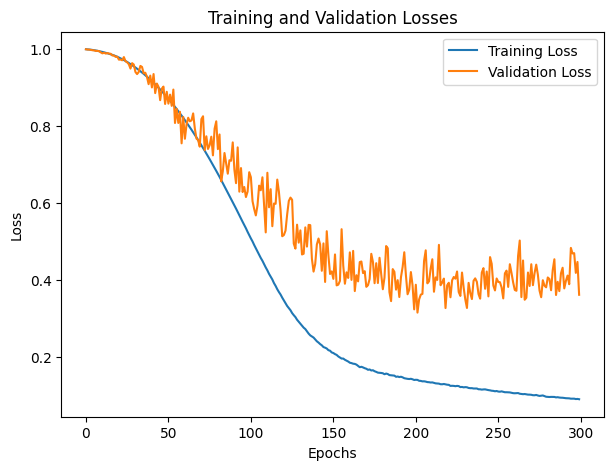

In [18]:
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xticks(range(0, len(train_losses), 1))  # Specify tick locations every 5 epochs
plt.legend()
plt.show()

In [19]:
model.eval()

test_loss = 0.0
test_image = []
ground_truth = []
predicted_patches = []

model.to(device)

with torch.no_grad():
    for batch in test_loader:
        # moving data to device
        images = batch['ct_generated'].float().to(device)
        std_maps = batch['std_map'].float().to(device)
        
        images = images.unsqueeze(0)
        std_maps = std_maps.unsqueeze(0)

        y_pred = model(images)

        # calculating loss
        loss = average_relative_error(y_pred, std_maps)
        test_loss += loss.item() * images.size(0)
        y_pred = y_pred.unsqueeze(0)

        # appending data for visualization
        test_image.append(images.cpu().numpy())
        ground_truth.append(std_maps.cpu().numpy())
        predicted_patches.append(y_pred.cpu().numpy())

# calculating average test loss
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.2924


In [35]:
# visualizing prediction

test_image_array = np.array(test_image)
ground_truth_array = np.array(ground_truth)
predicted_patches_array = np.array(predicted_patches)

test_image_array = test_image_array.reshape(8,8,64,64)
ground_truth_array = ground_truth_array.reshape(8,8,64,64)
predicted_patches_array = predicted_patches_array.reshape(8,8,64,64)

test_image_final = np.concatenate([np.concatenate(row, axis=1) for row in test_image_array], axis=0)
ground_truth_final = np.concatenate([np.concatenate(row, axis=1) for row in ground_truth_array], axis=0)
predicted_patches_final = np.concatenate([np.concatenate(row, axis=1) for row in predicted_patches_array], axis=0)


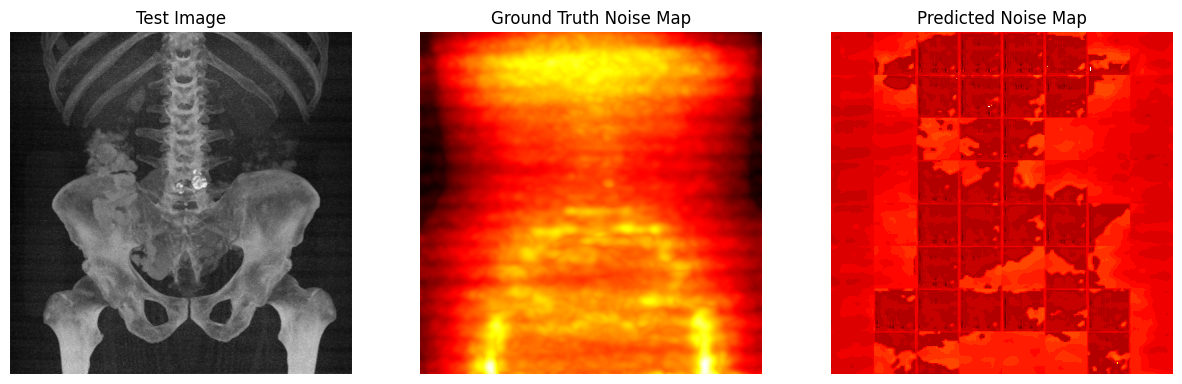

In [61]:
# Plot the test image
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(np.rot90(test_image_final), cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.rot90(ground_truth_final), cmap='hot')
plt.title('Ground Truth Noise Map')
plt.axis('off')

# Brightness factor (adjust as needed)
brightness_factor = 8.0

# Create a brighter version of the 'hot' colormap
hot_brighter = plt.cm.hot(np.linspace(0, brightness_factor, 256))
hot_brighter = ListedColormap(hot_brighter)

plt.subplot(133)
# Plot the image with the brighter colormap
plt.imshow(np.rot90(predicted_patches_final), cmap=hot_brighter)
plt.title('Predicted Noise Map')
plt.axis('off')
plt.show()

## Section-5 (a): Testing UNet without dropout

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels = None):
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
            
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv_op(x)
    
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [15]:
# initializing the model and optimizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(n_channels = 1, n_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
model_saving_path = '/projectnb/ec500kb/projects/Project6/'

In [18]:
# training and validation

train_losses = []
val_losses = []
num_epochs = 300

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        img = img.unsqueeze(0)
        std_map = images['std_map'].float().to(device)
        std_map = std_map.unsqueeze(0)
        #print(img.shape)
        #print(std_map.shape)
        optimizer.zero_grad()
        y_pred = model(img)
        #print(y_pred.shape)
        loss = average_relative_error(y_pred, std_map)
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            img = img.unsqueeze(0)
            std_map = image['std_map'].float().to(device)
            std_map = std_map.unsqueeze(0)

            y_pred = model(img)
            val_loss = average_relative_error(y_pred, std_map)
            #val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

100%|██████████| 72/72 [00:00<00:00, 447.93it/s]


Epoch [1/300], Train Loss: 0.9997, Validation Loss: 0.9995


100%|██████████| 72/72 [00:00<00:00, 455.23it/s]


Epoch [2/300], Train Loss: 0.9993, Validation Loss: 0.9991


100%|██████████| 72/72 [00:00<00:00, 456.34it/s]


Epoch [3/300], Train Loss: 0.9989, Validation Loss: 0.9985


100%|██████████| 72/72 [00:00<00:00, 454.05it/s]


Epoch [4/300], Train Loss: 0.9984, Validation Loss: 0.9979


100%|██████████| 72/72 [00:00<00:00, 455.14it/s]


Epoch [5/300], Train Loss: 0.9978, Validation Loss: 0.9971


100%|██████████| 72/72 [00:00<00:00, 456.16it/s]


Epoch [6/300], Train Loss: 0.9972, Validation Loss: 0.9969


100%|██████████| 72/72 [00:00<00:00, 454.72it/s]


Epoch [7/300], Train Loss: 0.9965, Validation Loss: 0.9963


100%|██████████| 72/72 [00:00<00:00, 455.35it/s]


Epoch [8/300], Train Loss: 0.9956, Validation Loss: 0.9935


100%|██████████| 72/72 [00:00<00:00, 454.69it/s]


Epoch [9/300], Train Loss: 0.9946, Validation Loss: 0.9928


100%|██████████| 72/72 [00:00<00:00, 455.35it/s]


Epoch [10/300], Train Loss: 0.9935, Validation Loss: 0.9927


100%|██████████| 72/72 [00:00<00:00, 455.82it/s]


Epoch [11/300], Train Loss: 0.9924, Validation Loss: 0.9920


100%|██████████| 72/72 [00:00<00:00, 456.67it/s]


Epoch [12/300], Train Loss: 0.9912, Validation Loss: 0.9878


100%|██████████| 72/72 [00:00<00:00, 456.10it/s]


Epoch [13/300], Train Loss: 0.9899, Validation Loss: 0.9856


100%|██████████| 72/72 [00:00<00:00, 456.76it/s]


Epoch [14/300], Train Loss: 0.9884, Validation Loss: 0.9852


100%|██████████| 72/72 [00:00<00:00, 455.85it/s]


Epoch [15/300], Train Loss: 0.9868, Validation Loss: 0.9851


100%|██████████| 72/72 [00:00<00:00, 454.63it/s]


Epoch [16/300], Train Loss: 0.9851, Validation Loss: 0.9852


100%|██████████| 72/72 [00:00<00:00, 455.12it/s]


Epoch [17/300], Train Loss: 0.9832, Validation Loss: 0.9860


100%|██████████| 72/72 [00:00<00:00, 455.20it/s]


Epoch [18/300], Train Loss: 0.9813, Validation Loss: 0.9806


100%|██████████| 72/72 [00:00<00:00, 455.37it/s]


Epoch [19/300], Train Loss: 0.9793, Validation Loss: 0.9719


100%|██████████| 72/72 [00:00<00:00, 455.00it/s]


Epoch [20/300], Train Loss: 0.9771, Validation Loss: 0.9738


100%|██████████| 72/72 [00:00<00:00, 455.28it/s]


Epoch [21/300], Train Loss: 0.9749, Validation Loss: 0.9729


100%|██████████| 72/72 [00:00<00:00, 455.67it/s]


Epoch [22/300], Train Loss: 0.9726, Validation Loss: 0.9703


100%|██████████| 72/72 [00:00<00:00, 454.07it/s]


Epoch [23/300], Train Loss: 0.9702, Validation Loss: 0.9713


100%|██████████| 72/72 [00:00<00:00, 454.92it/s]


Epoch [24/300], Train Loss: 0.9677, Validation Loss: 0.9759


100%|██████████| 72/72 [00:00<00:00, 452.97it/s]


Epoch [25/300], Train Loss: 0.9651, Validation Loss: 0.9593


100%|██████████| 72/72 [00:00<00:00, 454.12it/s]


Epoch [26/300], Train Loss: 0.9624, Validation Loss: 0.9577


100%|██████████| 72/72 [00:00<00:00, 453.57it/s]


Epoch [27/300], Train Loss: 0.9594, Validation Loss: 0.9641


100%|██████████| 72/72 [00:00<00:00, 454.65it/s]


Epoch [28/300], Train Loss: 0.9564, Validation Loss: 0.9429


100%|██████████| 72/72 [00:00<00:00, 452.61it/s]


Epoch [29/300], Train Loss: 0.9533, Validation Loss: 0.9512


100%|██████████| 72/72 [00:00<00:00, 453.50it/s]


Epoch [30/300], Train Loss: 0.9502, Validation Loss: 0.9391


100%|██████████| 72/72 [00:00<00:00, 453.29it/s]


Epoch [31/300], Train Loss: 0.9469, Validation Loss: 0.9483


100%|██████████| 72/72 [00:00<00:00, 452.47it/s]


Epoch [32/300], Train Loss: 0.9435, Validation Loss: 0.9530


100%|██████████| 72/72 [00:00<00:00, 461.02it/s]


Epoch [33/300], Train Loss: 0.9401, Validation Loss: 0.9458


100%|██████████| 72/72 [00:00<00:00, 454.50it/s]


Epoch [34/300], Train Loss: 0.9365, Validation Loss: 0.9320


100%|██████████| 72/72 [00:00<00:00, 453.69it/s]


Epoch [35/300], Train Loss: 0.9329, Validation Loss: 0.9351


100%|██████████| 72/72 [00:00<00:00, 454.41it/s]


Epoch [36/300], Train Loss: 0.9291, Validation Loss: 0.9356


100%|██████████| 72/72 [00:00<00:00, 453.40it/s]


Epoch [37/300], Train Loss: 0.9253, Validation Loss: 0.9327


100%|██████████| 72/72 [00:00<00:00, 455.26it/s]


Epoch [38/300], Train Loss: 0.9214, Validation Loss: 0.9284


100%|██████████| 72/72 [00:00<00:00, 453.28it/s]


Epoch [39/300], Train Loss: 0.9174, Validation Loss: 0.9131


100%|██████████| 72/72 [00:00<00:00, 454.12it/s]


Epoch [40/300], Train Loss: 0.9133, Validation Loss: 0.9115


100%|██████████| 72/72 [00:00<00:00, 451.99it/s]


Epoch [41/300], Train Loss: 0.9090, Validation Loss: 0.9291


100%|██████████| 72/72 [00:00<00:00, 443.50it/s]


Epoch [42/300], Train Loss: 0.9046, Validation Loss: 0.8817


100%|██████████| 72/72 [00:00<00:00, 452.04it/s]


Epoch [43/300], Train Loss: 0.9001, Validation Loss: 0.8903


100%|██████████| 72/72 [00:00<00:00, 458.09it/s]


Epoch [44/300], Train Loss: 0.8957, Validation Loss: 0.8898


100%|██████████| 72/72 [00:00<00:00, 455.22it/s]


Epoch [45/300], Train Loss: 0.8911, Validation Loss: 0.9087


100%|██████████| 72/72 [00:00<00:00, 453.68it/s]


Epoch [46/300], Train Loss: 0.8864, Validation Loss: 0.8878


100%|██████████| 72/72 [00:00<00:00, 451.91it/s]


Epoch [47/300], Train Loss: 0.8815, Validation Loss: 0.8476


100%|██████████| 72/72 [00:00<00:00, 455.10it/s]


Epoch [48/300], Train Loss: 0.8766, Validation Loss: 0.8564


100%|██████████| 72/72 [00:00<00:00, 456.32it/s]


Epoch [49/300], Train Loss: 0.8716, Validation Loss: 0.8765


100%|██████████| 72/72 [00:00<00:00, 459.29it/s]


Epoch [50/300], Train Loss: 0.8665, Validation Loss: 0.8810


100%|██████████| 72/72 [00:00<00:00, 461.43it/s]


Epoch [51/300], Train Loss: 0.8612, Validation Loss: 0.8793


100%|██████████| 72/72 [00:00<00:00, 461.89it/s]


Epoch [52/300], Train Loss: 0.8560, Validation Loss: 0.9075


100%|██████████| 72/72 [00:00<00:00, 460.61it/s]


Epoch [53/300], Train Loss: 0.8506, Validation Loss: 0.8625


100%|██████████| 72/72 [00:00<00:00, 462.43it/s]


Epoch [54/300], Train Loss: 0.8450, Validation Loss: 0.8403


100%|██████████| 72/72 [00:00<00:00, 461.96it/s]


Epoch [55/300], Train Loss: 0.8396, Validation Loss: 0.8389


100%|██████████| 72/72 [00:00<00:00, 462.32it/s]


Epoch [56/300], Train Loss: 0.8338, Validation Loss: 0.8070


100%|██████████| 72/72 [00:00<00:00, 461.81it/s]


Epoch [57/300], Train Loss: 0.8280, Validation Loss: 0.8361


100%|██████████| 72/72 [00:00<00:00, 462.94it/s]


Epoch [58/300], Train Loss: 0.8221, Validation Loss: 0.8440


100%|██████████| 72/72 [00:00<00:00, 461.88it/s]


Epoch [59/300], Train Loss: 0.8162, Validation Loss: 0.8045


100%|██████████| 72/72 [00:00<00:00, 463.19it/s]


Epoch [60/300], Train Loss: 0.8099, Validation Loss: 0.8040


100%|██████████| 72/72 [00:00<00:00, 463.44it/s]


Epoch [61/300], Train Loss: 0.8037, Validation Loss: 0.7782


100%|██████████| 72/72 [00:00<00:00, 463.01it/s]


Epoch [62/300], Train Loss: 0.7969, Validation Loss: 0.8197


100%|██████████| 72/72 [00:00<00:00, 462.28it/s]


Epoch [63/300], Train Loss: 0.7899, Validation Loss: 0.8187


100%|██████████| 72/72 [00:00<00:00, 463.94it/s]


Epoch [64/300], Train Loss: 0.7834, Validation Loss: 0.8083


100%|██████████| 72/72 [00:00<00:00, 462.17it/s]


Epoch [65/300], Train Loss: 0.7767, Validation Loss: 0.7563


100%|██████████| 72/72 [00:00<00:00, 463.75it/s]


Epoch [66/300], Train Loss: 0.7700, Validation Loss: 0.8053


100%|██████████| 72/72 [00:00<00:00, 463.24it/s]


Epoch [67/300], Train Loss: 0.7632, Validation Loss: 0.8058


100%|██████████| 72/72 [00:00<00:00, 464.59it/s]


Epoch [68/300], Train Loss: 0.7563, Validation Loss: 0.8048


100%|██████████| 72/72 [00:00<00:00, 462.61it/s]


Epoch [69/300], Train Loss: 0.7493, Validation Loss: 0.7251


100%|██████████| 72/72 [00:00<00:00, 463.25it/s]


Epoch [70/300], Train Loss: 0.7422, Validation Loss: 0.7987


100%|██████████| 72/72 [00:00<00:00, 464.60it/s]


Epoch [71/300], Train Loss: 0.7351, Validation Loss: 0.7802


100%|██████████| 72/72 [00:00<00:00, 465.67it/s]


Epoch [72/300], Train Loss: 0.7277, Validation Loss: 0.7209


100%|██████████| 72/72 [00:00<00:00, 465.95it/s]


Epoch [73/300], Train Loss: 0.7206, Validation Loss: 0.7723


100%|██████████| 72/72 [00:00<00:00, 465.76it/s]


Epoch [74/300], Train Loss: 0.7132, Validation Loss: 0.7976


100%|██████████| 72/72 [00:00<00:00, 461.67it/s]


Epoch [75/300], Train Loss: 0.7056, Validation Loss: 0.7311


100%|██████████| 72/72 [00:00<00:00, 465.90it/s]


Epoch [76/300], Train Loss: 0.6982, Validation Loss: 0.7522


100%|██████████| 72/72 [00:00<00:00, 464.31it/s]


Epoch [77/300], Train Loss: 0.6904, Validation Loss: 0.7492


100%|██████████| 72/72 [00:00<00:00, 465.51it/s]


Epoch [78/300], Train Loss: 0.6827, Validation Loss: 0.7857


100%|██████████| 72/72 [00:00<00:00, 465.59it/s]


Epoch [79/300], Train Loss: 0.6747, Validation Loss: 0.7326


100%|██████████| 72/72 [00:00<00:00, 465.72it/s]


Epoch [80/300], Train Loss: 0.6667, Validation Loss: 0.7809


100%|██████████| 72/72 [00:00<00:00, 465.76it/s]


Epoch [81/300], Train Loss: 0.6589, Validation Loss: 0.7131


100%|██████████| 72/72 [00:00<00:00, 465.72it/s]


Epoch [82/300], Train Loss: 0.6509, Validation Loss: 0.7563


100%|██████████| 72/72 [00:00<00:00, 465.02it/s]


Epoch [83/300], Train Loss: 0.6426, Validation Loss: 0.6616


100%|██████████| 72/72 [00:00<00:00, 466.63it/s]


Epoch [84/300], Train Loss: 0.6345, Validation Loss: 0.8025


100%|██████████| 72/72 [00:00<00:00, 465.29it/s]


Epoch [85/300], Train Loss: 0.6261, Validation Loss: 0.7304


100%|██████████| 72/72 [00:00<00:00, 465.81it/s]


Epoch [86/300], Train Loss: 0.6179, Validation Loss: 0.7161


100%|██████████| 72/72 [00:00<00:00, 457.32it/s]


Epoch [87/300], Train Loss: 0.6093, Validation Loss: 0.6765


100%|██████████| 72/72 [00:00<00:00, 467.04it/s]


Epoch [88/300], Train Loss: 0.6010, Validation Loss: 0.6702


100%|██████████| 72/72 [00:00<00:00, 461.12it/s]


Epoch [89/300], Train Loss: 0.5925, Validation Loss: 0.6684


100%|██████████| 72/72 [00:00<00:00, 465.25it/s]


Epoch [90/300], Train Loss: 0.5840, Validation Loss: 0.6889


100%|██████████| 72/72 [00:00<00:00, 463.03it/s]


Epoch [91/300], Train Loss: 0.5755, Validation Loss: 0.6533


100%|██████████| 72/72 [00:00<00:00, 464.40it/s]


Epoch [92/300], Train Loss: 0.5668, Validation Loss: 0.6359


100%|██████████| 72/72 [00:00<00:00, 463.67it/s]


Epoch [93/300], Train Loss: 0.5583, Validation Loss: 0.7055


100%|██████████| 72/72 [00:00<00:00, 464.57it/s]


Epoch [94/300], Train Loss: 0.5495, Validation Loss: 0.6640


100%|██████████| 72/72 [00:00<00:00, 463.49it/s]


Epoch [95/300], Train Loss: 0.5408, Validation Loss: 0.7038


100%|██████████| 72/72 [00:00<00:00, 464.53it/s]


Epoch [96/300], Train Loss: 0.5321, Validation Loss: 0.6835


100%|██████████| 72/72 [00:00<00:00, 463.26it/s]


Epoch [97/300], Train Loss: 0.5231, Validation Loss: 0.6526


100%|██████████| 72/72 [00:00<00:00, 467.17it/s]


Epoch [98/300], Train Loss: 0.5145, Validation Loss: 0.6770


100%|██████████| 72/72 [00:00<00:00, 464.57it/s]


Epoch [99/300], Train Loss: 0.5061, Validation Loss: 0.6193


100%|██████████| 72/72 [00:00<00:00, 465.70it/s]


Epoch [100/300], Train Loss: 0.4978, Validation Loss: 0.7242


100%|██████████| 72/72 [00:00<00:00, 464.63it/s]


Epoch [101/300], Train Loss: 0.4893, Validation Loss: 0.5945


100%|██████████| 72/72 [00:00<00:00, 465.23it/s]


Epoch [102/300], Train Loss: 0.4804, Validation Loss: 0.6537


100%|██████████| 72/72 [00:00<00:00, 464.44it/s]


Epoch [103/300], Train Loss: 0.4722, Validation Loss: 0.6374


100%|██████████| 72/72 [00:00<00:00, 465.85it/s]


Epoch [104/300], Train Loss: 0.4634, Validation Loss: 0.6096


100%|██████████| 72/72 [00:00<00:00, 465.65it/s]


Epoch [105/300], Train Loss: 0.4548, Validation Loss: 0.6055


100%|██████████| 72/72 [00:00<00:00, 465.50it/s]


Epoch [106/300], Train Loss: 0.4462, Validation Loss: 0.6337


100%|██████████| 72/72 [00:00<00:00, 462.97it/s]


Epoch [107/300], Train Loss: 0.4384, Validation Loss: 0.5825


100%|██████████| 72/72 [00:00<00:00, 463.35it/s]


Epoch [108/300], Train Loss: 0.4292, Validation Loss: 0.5734


100%|██████████| 72/72 [00:00<00:00, 463.88it/s]


Epoch [109/300], Train Loss: 0.4217, Validation Loss: 0.5743


100%|██████████| 72/72 [00:00<00:00, 464.46it/s]


Epoch [110/300], Train Loss: 0.4135, Validation Loss: 0.5476


100%|██████████| 72/72 [00:00<00:00, 465.73it/s]


Epoch [111/300], Train Loss: 0.4056, Validation Loss: 0.5841


100%|██████████| 72/72 [00:00<00:00, 466.44it/s]


Epoch [112/300], Train Loss: 0.3965, Validation Loss: 0.6350


100%|██████████| 72/72 [00:00<00:00, 464.44it/s]


Epoch [113/300], Train Loss: 0.3893, Validation Loss: 0.6018


100%|██████████| 72/72 [00:00<00:00, 464.90it/s]


Epoch [114/300], Train Loss: 0.3831, Validation Loss: 0.5306


100%|██████████| 72/72 [00:00<00:00, 463.18it/s]


Epoch [115/300], Train Loss: 0.3744, Validation Loss: 0.6400


100%|██████████| 72/72 [00:00<00:00, 464.46it/s]


Epoch [116/300], Train Loss: 0.3662, Validation Loss: 0.6247


100%|██████████| 72/72 [00:00<00:00, 463.25it/s]


Epoch [117/300], Train Loss: 0.3590, Validation Loss: 0.5705


100%|██████████| 72/72 [00:00<00:00, 465.91it/s]


Epoch [118/300], Train Loss: 0.3511, Validation Loss: 0.6034


100%|██████████| 72/72 [00:00<00:00, 464.45it/s]


Epoch [119/300], Train Loss: 0.3447, Validation Loss: 0.6193


100%|██████████| 72/72 [00:00<00:00, 465.20it/s]


Epoch [120/300], Train Loss: 0.3380, Validation Loss: 0.5567


100%|██████████| 72/72 [00:00<00:00, 464.27it/s]


Epoch [121/300], Train Loss: 0.3322, Validation Loss: 0.5988


100%|██████████| 72/72 [00:00<00:00, 465.15it/s]


Epoch [122/300], Train Loss: 0.3246, Validation Loss: 0.6069


100%|██████████| 72/72 [00:00<00:00, 464.57it/s]


Epoch [123/300], Train Loss: 0.3193, Validation Loss: 0.5527


100%|██████████| 72/72 [00:00<00:00, 464.51it/s]


Epoch [124/300], Train Loss: 0.3127, Validation Loss: 0.6400


100%|██████████| 72/72 [00:00<00:00, 464.37it/s]


Epoch [125/300], Train Loss: 0.3058, Validation Loss: 0.5195


100%|██████████| 72/72 [00:00<00:00, 464.85it/s]


Epoch [126/300], Train Loss: 0.3022, Validation Loss: 0.6061


100%|██████████| 72/72 [00:00<00:00, 465.74it/s]


Epoch [127/300], Train Loss: 0.2965, Validation Loss: 0.5153


100%|██████████| 72/72 [00:00<00:00, 462.74it/s]


Epoch [128/300], Train Loss: 0.2897, Validation Loss: 0.5399


100%|██████████| 72/72 [00:00<00:00, 464.33it/s]


Epoch [129/300], Train Loss: 0.2845, Validation Loss: 0.5676


100%|██████████| 72/72 [00:00<00:00, 465.57it/s]


Epoch [130/300], Train Loss: 0.2813, Validation Loss: 0.4616


100%|██████████| 72/72 [00:00<00:00, 462.28it/s]


Epoch [131/300], Train Loss: 0.2741, Validation Loss: 0.5271


100%|██████████| 72/72 [00:00<00:00, 465.06it/s]


Epoch [132/300], Train Loss: 0.2704, Validation Loss: 0.5772


100%|██████████| 72/72 [00:00<00:00, 458.08it/s]


Epoch [133/300], Train Loss: 0.2643, Validation Loss: 0.5336


100%|██████████| 72/72 [00:00<00:00, 465.81it/s]


Epoch [134/300], Train Loss: 0.2606, Validation Loss: 0.4883


100%|██████████| 72/72 [00:00<00:00, 464.13it/s]


Epoch [135/300], Train Loss: 0.2559, Validation Loss: 0.4700


100%|██████████| 72/72 [00:00<00:00, 465.36it/s]


Epoch [136/300], Train Loss: 0.2518, Validation Loss: 0.5167


100%|██████████| 72/72 [00:00<00:00, 465.46it/s]


Epoch [137/300], Train Loss: 0.2477, Validation Loss: 0.4348


100%|██████████| 72/72 [00:00<00:00, 466.14it/s]


Epoch [138/300], Train Loss: 0.2446, Validation Loss: 0.4937


100%|██████████| 72/72 [00:00<00:00, 464.46it/s]


Epoch [139/300], Train Loss: 0.2400, Validation Loss: 0.4798


100%|██████████| 72/72 [00:00<00:00, 465.70it/s]


Epoch [140/300], Train Loss: 0.2377, Validation Loss: 0.4655


100%|██████████| 72/72 [00:00<00:00, 464.12it/s]


Epoch [141/300], Train Loss: 0.2337, Validation Loss: 0.4107


100%|██████████| 72/72 [00:00<00:00, 465.50it/s]


Epoch [142/300], Train Loss: 0.2302, Validation Loss: 0.4391


100%|██████████| 72/72 [00:00<00:00, 464.63it/s]


Epoch [143/300], Train Loss: 0.2264, Validation Loss: 0.4606


100%|██████████| 72/72 [00:00<00:00, 465.64it/s]


Epoch [144/300], Train Loss: 0.2244, Validation Loss: 0.4254


100%|██████████| 72/72 [00:00<00:00, 458.65it/s]


Epoch [145/300], Train Loss: 0.2191, Validation Loss: 0.4270


100%|██████████| 72/72 [00:00<00:00, 465.81it/s]


Epoch [146/300], Train Loss: 0.2165, Validation Loss: 0.4861


100%|██████████| 72/72 [00:00<00:00, 466.03it/s]


Epoch [147/300], Train Loss: 0.2122, Validation Loss: 0.5081


100%|██████████| 72/72 [00:00<00:00, 467.21it/s]


Epoch [148/300], Train Loss: 0.2110, Validation Loss: 0.4500


100%|██████████| 72/72 [00:00<00:00, 464.58it/s]


Epoch [149/300], Train Loss: 0.2073, Validation Loss: 0.3933


100%|██████████| 72/72 [00:00<00:00, 427.42it/s]


Epoch [150/300], Train Loss: 0.2039, Validation Loss: 0.4211


100%|██████████| 72/72 [00:00<00:00, 435.10it/s]


Epoch [151/300], Train Loss: 0.2014, Validation Loss: 0.3631


100%|██████████| 72/72 [00:00<00:00, 463.51it/s]


Epoch [152/300], Train Loss: 0.1980, Validation Loss: 0.4141


100%|██████████| 72/72 [00:00<00:00, 463.49it/s]


Epoch [153/300], Train Loss: 0.1966, Validation Loss: 0.4298


100%|██████████| 72/72 [00:00<00:00, 463.93it/s]


Epoch [154/300], Train Loss: 0.1944, Validation Loss: 0.3892


100%|██████████| 72/72 [00:00<00:00, 463.36it/s]


Epoch [155/300], Train Loss: 0.1917, Validation Loss: 0.4075


100%|██████████| 72/72 [00:00<00:00, 448.14it/s]


Epoch [156/300], Train Loss: 0.1889, Validation Loss: 0.4212


100%|██████████| 72/72 [00:00<00:00, 472.51it/s]


Epoch [157/300], Train Loss: 0.1867, Validation Loss: 0.3785


100%|██████████| 72/72 [00:00<00:00, 470.44it/s]


Epoch [158/300], Train Loss: 0.1851, Validation Loss: 0.4129


100%|██████████| 72/72 [00:00<00:00, 472.25it/s]


Epoch [159/300], Train Loss: 0.1811, Validation Loss: 0.4064


100%|██████████| 72/72 [00:00<00:00, 474.24it/s]


Epoch [160/300], Train Loss: 0.1814, Validation Loss: 0.3752


100%|██████████| 72/72 [00:00<00:00, 467.88it/s]


Epoch [161/300], Train Loss: 0.1786, Validation Loss: 0.3862


100%|██████████| 72/72 [00:00<00:00, 471.56it/s]


Epoch [162/300], Train Loss: 0.1768, Validation Loss: 0.3849


100%|██████████| 72/72 [00:00<00:00, 463.10it/s]


Epoch [163/300], Train Loss: 0.1755, Validation Loss: 0.3617


100%|██████████| 72/72 [00:00<00:00, 464.00it/s]


Epoch [164/300], Train Loss: 0.1747, Validation Loss: 0.3833


100%|██████████| 72/72 [00:00<00:00, 470.35it/s]


Epoch [165/300], Train Loss: 0.1713, Validation Loss: 0.3574


100%|██████████| 72/72 [00:00<00:00, 472.18it/s]


Epoch [166/300], Train Loss: 0.1702, Validation Loss: 0.3657


100%|██████████| 72/72 [00:00<00:00, 472.45it/s]


Epoch [167/300], Train Loss: 0.1687, Validation Loss: 0.3752


100%|██████████| 72/72 [00:00<00:00, 471.79it/s]


Epoch [168/300], Train Loss: 0.1670, Validation Loss: 0.3855


100%|██████████| 72/72 [00:00<00:00, 471.25it/s]


Epoch [169/300], Train Loss: 0.1655, Validation Loss: 0.3666


100%|██████████| 72/72 [00:00<00:00, 467.42it/s]


Epoch [170/300], Train Loss: 0.1639, Validation Loss: 0.4132


100%|██████████| 72/72 [00:00<00:00, 465.07it/s]


Epoch [171/300], Train Loss: 0.1624, Validation Loss: 0.3766


100%|██████████| 72/72 [00:00<00:00, 464.73it/s]


Epoch [172/300], Train Loss: 0.1608, Validation Loss: 0.3543


100%|██████████| 72/72 [00:00<00:00, 465.41it/s]


Epoch [173/300], Train Loss: 0.1586, Validation Loss: 0.3607


100%|██████████| 72/72 [00:00<00:00, 473.35it/s]


Epoch [174/300], Train Loss: 0.1569, Validation Loss: 0.3262


100%|██████████| 72/72 [00:00<00:00, 463.70it/s]


Epoch [175/300], Train Loss: 0.1579, Validation Loss: 0.3598


100%|██████████| 72/72 [00:00<00:00, 467.80it/s]


Epoch [176/300], Train Loss: 0.1572, Validation Loss: 0.3399


100%|██████████| 72/72 [00:00<00:00, 466.54it/s]


Epoch [177/300], Train Loss: 0.1558, Validation Loss: 0.3520


100%|██████████| 72/72 [00:00<00:00, 464.91it/s]


Epoch [178/300], Train Loss: 0.1537, Validation Loss: 0.3586


100%|██████████| 72/72 [00:00<00:00, 471.60it/s]


Epoch [179/300], Train Loss: 0.1531, Validation Loss: 0.3122


100%|██████████| 72/72 [00:00<00:00, 472.55it/s]


Epoch [180/300], Train Loss: 0.1525, Validation Loss: 0.3562


100%|██████████| 72/72 [00:00<00:00, 474.03it/s]


Epoch [181/300], Train Loss: 0.1507, Validation Loss: 0.3403


100%|██████████| 72/72 [00:00<00:00, 468.41it/s]


Epoch [182/300], Train Loss: 0.1483, Validation Loss: 0.3545


100%|██████████| 72/72 [00:00<00:00, 463.92it/s]


Epoch [183/300], Train Loss: 0.1495, Validation Loss: 0.3545


100%|██████████| 72/72 [00:00<00:00, 466.62it/s]


Epoch [184/300], Train Loss: 0.1471, Validation Loss: 0.3133


100%|██████████| 72/72 [00:00<00:00, 472.54it/s]


Epoch [185/300], Train Loss: 0.1468, Validation Loss: 0.3271


100%|██████████| 72/72 [00:00<00:00, 474.69it/s]


Epoch [186/300], Train Loss: 0.1461, Validation Loss: 0.3289


100%|██████████| 72/72 [00:00<00:00, 472.64it/s]


Epoch [187/300], Train Loss: 0.1456, Validation Loss: 0.3434


100%|██████████| 72/72 [00:00<00:00, 466.69it/s]


Epoch [188/300], Train Loss: 0.1438, Validation Loss: 0.3279


100%|██████████| 72/72 [00:00<00:00, 472.02it/s]


Epoch [189/300], Train Loss: 0.1442, Validation Loss: 0.3679


100%|██████████| 72/72 [00:00<00:00, 451.84it/s]


Epoch [190/300], Train Loss: 0.1416, Validation Loss: 0.2994


100%|██████████| 72/72 [00:00<00:00, 461.75it/s]


Epoch [191/300], Train Loss: 0.1407, Validation Loss: 0.3065


100%|██████████| 72/72 [00:00<00:00, 461.75it/s]


Epoch [192/300], Train Loss: 0.1406, Validation Loss: 0.3220


100%|██████████| 72/72 [00:00<00:00, 465.48it/s]


Epoch [193/300], Train Loss: 0.1416, Validation Loss: 0.3263


100%|██████████| 72/72 [00:00<00:00, 461.00it/s]


Epoch [194/300], Train Loss: 0.1400, Validation Loss: 0.3155


100%|██████████| 72/72 [00:00<00:00, 463.90it/s]


Epoch [195/300], Train Loss: 0.1397, Validation Loss: 0.3193


100%|██████████| 72/72 [00:00<00:00, 463.57it/s]


Epoch [196/300], Train Loss: 0.1378, Validation Loss: 0.2842


100%|██████████| 72/72 [00:00<00:00, 460.32it/s]


Epoch [197/300], Train Loss: 0.1375, Validation Loss: 0.3196


100%|██████████| 72/72 [00:00<00:00, 458.93it/s]


Epoch [198/300], Train Loss: 0.1365, Validation Loss: 0.3459


100%|██████████| 72/72 [00:00<00:00, 463.08it/s]


Epoch [199/300], Train Loss: 0.1374, Validation Loss: 0.3010


100%|██████████| 72/72 [00:00<00:00, 460.49it/s]


Epoch [200/300], Train Loss: 0.1349, Validation Loss: 0.3254


100%|██████████| 72/72 [00:00<00:00, 461.53it/s]


Epoch [201/300], Train Loss: 0.1351, Validation Loss: 0.3065


100%|██████████| 72/72 [00:00<00:00, 465.71it/s]


Epoch [202/300], Train Loss: 0.1345, Validation Loss: 0.3194


100%|██████████| 72/72 [00:00<00:00, 465.55it/s]


Epoch [203/300], Train Loss: 0.1341, Validation Loss: 0.3095


100%|██████████| 72/72 [00:00<00:00, 460.50it/s]


Epoch [204/300], Train Loss: 0.1340, Validation Loss: 0.3343


100%|██████████| 72/72 [00:00<00:00, 457.86it/s]


Epoch [205/300], Train Loss: 0.1319, Validation Loss: 0.3177


100%|██████████| 72/72 [00:00<00:00, 464.34it/s]


Epoch [206/300], Train Loss: 0.1319, Validation Loss: 0.3416


100%|██████████| 72/72 [00:00<00:00, 456.23it/s]


Epoch [207/300], Train Loss: 0.1319, Validation Loss: 0.3290


100%|██████████| 72/72 [00:00<00:00, 463.29it/s]


Epoch [208/300], Train Loss: 0.1306, Validation Loss: 0.3015


100%|██████████| 72/72 [00:00<00:00, 464.63it/s]


Epoch [209/300], Train Loss: 0.1297, Validation Loss: 0.3021


100%|██████████| 72/72 [00:00<00:00, 467.50it/s]


Epoch [210/300], Train Loss: 0.1303, Validation Loss: 0.3489


100%|██████████| 72/72 [00:00<00:00, 466.35it/s]


Epoch [211/300], Train Loss: 0.1305, Validation Loss: 0.3347


100%|██████████| 72/72 [00:00<00:00, 465.85it/s]


Epoch [212/300], Train Loss: 0.1294, Validation Loss: 0.2983


100%|██████████| 72/72 [00:00<00:00, 461.57it/s]


Epoch [213/300], Train Loss: 0.1275, Validation Loss: 0.3436


100%|██████████| 72/72 [00:00<00:00, 463.67it/s]


Epoch [214/300], Train Loss: 0.1277, Validation Loss: 0.3288


100%|██████████| 72/72 [00:00<00:00, 458.56it/s]


Epoch [215/300], Train Loss: 0.1280, Validation Loss: 0.3170


100%|██████████| 72/72 [00:00<00:00, 467.33it/s]


Epoch [216/300], Train Loss: 0.1266, Validation Loss: 0.3212


 65%|██████▌   | 47/72 [00:00<00:00, 469.10it/s]

Epoch [217/300], Train Loss: 0.1262, Validation Loss: 0.3009


100%|██████████| 72/72 [00:00<00:00, 461.10it/s]


Epoch [218/300], Train Loss: 0.1266, Validation Loss: 0.2567


100%|██████████| 72/72 [00:00<00:00, 461.09it/s]


Epoch [219/300], Train Loss: 0.1250, Validation Loss: 0.3059


100%|██████████| 72/72 [00:00<00:00, 464.58it/s]


Epoch [220/300], Train Loss: 0.1245, Validation Loss: 0.3485


100%|██████████| 72/72 [00:00<00:00, 460.17it/s]


Epoch [221/300], Train Loss: 0.1243, Validation Loss: 0.3533


100%|██████████| 72/72 [00:00<00:00, 467.33it/s]


Epoch [222/300], Train Loss: 0.1238, Validation Loss: 0.3242


100%|██████████| 72/72 [00:00<00:00, 465.55it/s]


Epoch [223/300], Train Loss: 0.1227, Validation Loss: 0.3178


100%|██████████| 72/72 [00:00<00:00, 462.41it/s]


Epoch [224/300], Train Loss: 0.1224, Validation Loss: 0.2847


100%|██████████| 72/72 [00:00<00:00, 463.42it/s]


Epoch [225/300], Train Loss: 0.1231, Validation Loss: 0.3087


100%|██████████| 72/72 [00:00<00:00, 468.25it/s]


Epoch [226/300], Train Loss: 0.1236, Validation Loss: 0.2817


100%|██████████| 72/72 [00:00<00:00, 467.06it/s]


Epoch [227/300], Train Loss: 0.1206, Validation Loss: 0.2713


100%|██████████| 72/72 [00:00<00:00, 463.98it/s]


Epoch [228/300], Train Loss: 0.1208, Validation Loss: 0.3230


100%|██████████| 72/72 [00:00<00:00, 467.00it/s]


Epoch [229/300], Train Loss: 0.1205, Validation Loss: 0.3018


100%|██████████| 72/72 [00:00<00:00, 470.68it/s]


Epoch [230/300], Train Loss: 0.1210, Validation Loss: 0.3185


100%|██████████| 72/72 [00:00<00:00, 473.42it/s]


Epoch [231/300], Train Loss: 0.1190, Validation Loss: 0.2959


100%|██████████| 72/72 [00:00<00:00, 472.92it/s]


Epoch [232/300], Train Loss: 0.1196, Validation Loss: 0.3433


100%|██████████| 72/72 [00:00<00:00, 469.47it/s]


Epoch [233/300], Train Loss: 0.1182, Validation Loss: 0.3332


100%|██████████| 72/72 [00:00<00:00, 473.92it/s]


Epoch [234/300], Train Loss: 0.1183, Validation Loss: 0.3061


100%|██████████| 72/72 [00:00<00:00, 472.37it/s]


Epoch [235/300], Train Loss: 0.1184, Validation Loss: 0.3521


100%|██████████| 72/72 [00:00<00:00, 471.20it/s]


Epoch [236/300], Train Loss: 0.1174, Validation Loss: 0.3206


100%|██████████| 72/72 [00:00<00:00, 472.54it/s]


Epoch [237/300], Train Loss: 0.1173, Validation Loss: 0.3104


100%|██████████| 72/72 [00:00<00:00, 472.72it/s]


Epoch [238/300], Train Loss: 0.1167, Validation Loss: 0.2581


100%|██████████| 72/72 [00:00<00:00, 470.51it/s]


Epoch [239/300], Train Loss: 0.1173, Validation Loss: 0.3524


100%|██████████| 72/72 [00:00<00:00, 468.83it/s]


Epoch [240/300], Train Loss: 0.1158, Validation Loss: 0.2499


100%|██████████| 72/72 [00:00<00:00, 472.20it/s]


Epoch [241/300], Train Loss: 0.1147, Validation Loss: 0.3464


100%|██████████| 72/72 [00:00<00:00, 471.37it/s]


Epoch [242/300], Train Loss: 0.1141, Validation Loss: 0.3303


100%|██████████| 72/72 [00:00<00:00, 468.83it/s]


Epoch [243/300], Train Loss: 0.1138, Validation Loss: 0.2973


100%|██████████| 72/72 [00:00<00:00, 472.59it/s]


Epoch [244/300], Train Loss: 0.1133, Validation Loss: 0.3020


100%|██████████| 72/72 [00:00<00:00, 463.54it/s]


Epoch [245/300], Train Loss: 0.1133, Validation Loss: 0.3315


100%|██████████| 72/72 [00:00<00:00, 472.52it/s]


Epoch [246/300], Train Loss: 0.1138, Validation Loss: 0.3492


100%|██████████| 72/72 [00:00<00:00, 472.68it/s]


Epoch [247/300], Train Loss: 0.1127, Validation Loss: 0.3301


100%|██████████| 72/72 [00:00<00:00, 473.52it/s]


Epoch [248/300], Train Loss: 0.1112, Validation Loss: 0.3293


100%|██████████| 72/72 [00:00<00:00, 468.47it/s]


Epoch [249/300], Train Loss: 0.1123, Validation Loss: 0.2989


100%|██████████| 72/72 [00:00<00:00, 469.81it/s]


Epoch [250/300], Train Loss: 0.1123, Validation Loss: 0.3235


100%|██████████| 72/72 [00:00<00:00, 469.02it/s]


Epoch [251/300], Train Loss: 0.1114, Validation Loss: 0.2422


100%|██████████| 72/72 [00:00<00:00, 472.98it/s]


Epoch [252/300], Train Loss: 0.1107, Validation Loss: 0.3117


100%|██████████| 72/72 [00:00<00:00, 472.15it/s]


Epoch [253/300], Train Loss: 0.1093, Validation Loss: 0.3107


100%|██████████| 72/72 [00:00<00:00, 467.32it/s]


Epoch [254/300], Train Loss: 0.1100, Validation Loss: 0.3758


100%|██████████| 72/72 [00:00<00:00, 468.86it/s]


Epoch [255/300], Train Loss: 0.1103, Validation Loss: 0.2840


100%|██████████| 72/72 [00:00<00:00, 469.12it/s]


Epoch [256/300], Train Loss: 0.1092, Validation Loss: 0.3399


100%|██████████| 72/72 [00:00<00:00, 465.22it/s]


Epoch [257/300], Train Loss: 0.1088, Validation Loss: 0.3182


100%|██████████| 72/72 [00:00<00:00, 466.76it/s]


Epoch [258/300], Train Loss: 0.1087, Validation Loss: 0.3620


100%|██████████| 72/72 [00:00<00:00, 468.51it/s]


Epoch [259/300], Train Loss: 0.1078, Validation Loss: 0.3291


100%|██████████| 72/72 [00:00<00:00, 470.18it/s]


Epoch [260/300], Train Loss: 0.1077, Validation Loss: 0.2926


100%|██████████| 72/72 [00:00<00:00, 469.32it/s]


Epoch [261/300], Train Loss: 0.1066, Validation Loss: 0.3566


100%|██████████| 72/72 [00:00<00:00, 469.54it/s]


Epoch [262/300], Train Loss: 0.1053, Validation Loss: 0.3081


100%|██████████| 72/72 [00:00<00:00, 469.27it/s]


Epoch [263/300], Train Loss: 0.1056, Validation Loss: 0.3486


100%|██████████| 72/72 [00:00<00:00, 468.99it/s]


Epoch [264/300], Train Loss: 0.1063, Validation Loss: 0.2824


100%|██████████| 72/72 [00:00<00:00, 467.67it/s]


Epoch [265/300], Train Loss: 0.1051, Validation Loss: 0.2940


100%|██████████| 72/72 [00:00<00:00, 469.89it/s]


Epoch [266/300], Train Loss: 0.1050, Validation Loss: 0.3027


100%|██████████| 72/72 [00:00<00:00, 469.36it/s]


Epoch [267/300], Train Loss: 0.1048, Validation Loss: 0.3223


100%|██████████| 72/72 [00:00<00:00, 469.91it/s]


Epoch [268/300], Train Loss: 0.1037, Validation Loss: 0.2949


100%|██████████| 72/72 [00:00<00:00, 467.16it/s]


Epoch [269/300], Train Loss: 0.1049, Validation Loss: 0.3206


100%|██████████| 72/72 [00:00<00:00, 468.27it/s]


Epoch [270/300], Train Loss: 0.1038, Validation Loss: 0.3467


100%|██████████| 72/72 [00:00<00:00, 471.73it/s]


Epoch [271/300], Train Loss: 0.1040, Validation Loss: 0.3008


100%|██████████| 72/72 [00:00<00:00, 471.68it/s]


Epoch [272/300], Train Loss: 0.1032, Validation Loss: 0.2782


100%|██████████| 72/72 [00:00<00:00, 471.12it/s]


Epoch [273/300], Train Loss: 0.1019, Validation Loss: 0.3384


100%|██████████| 72/72 [00:00<00:00, 466.89it/s]


Epoch [274/300], Train Loss: 0.1016, Validation Loss: 0.2611


100%|██████████| 72/72 [00:00<00:00, 469.46it/s]


Epoch [275/300], Train Loss: 0.1022, Validation Loss: 0.3122


100%|██████████| 72/72 [00:00<00:00, 470.66it/s]


Epoch [276/300], Train Loss: 0.1013, Validation Loss: 0.3441


100%|██████████| 72/72 [00:00<00:00, 469.90it/s]


Epoch [277/300], Train Loss: 0.1012, Validation Loss: 0.3355


100%|██████████| 72/72 [00:00<00:00, 474.48it/s]


Epoch [278/300], Train Loss: 0.1000, Validation Loss: 0.2903


100%|██████████| 72/72 [00:00<00:00, 468.83it/s]


Epoch [279/300], Train Loss: 0.1004, Validation Loss: 0.3640


100%|██████████| 72/72 [00:00<00:00, 469.99it/s]


Epoch [280/300], Train Loss: 0.0986, Validation Loss: 0.2995


100%|██████████| 72/72 [00:00<00:00, 474.20it/s]


Epoch [281/300], Train Loss: 0.0985, Validation Loss: 0.2442


100%|██████████| 72/72 [00:00<00:00, 470.29it/s]


Epoch [282/300], Train Loss: 0.0988, Validation Loss: 0.3168


100%|██████████| 72/72 [00:00<00:00, 474.70it/s]


Epoch [283/300], Train Loss: 0.0988, Validation Loss: 0.3410


100%|██████████| 72/72 [00:00<00:00, 474.28it/s]


Epoch [284/300], Train Loss: 0.0976, Validation Loss: 0.3200


100%|██████████| 72/72 [00:00<00:00, 474.57it/s]


Epoch [285/300], Train Loss: 0.0980, Validation Loss: 0.3333


100%|██████████| 72/72 [00:00<00:00, 474.97it/s]


Epoch [286/300], Train Loss: 0.0985, Validation Loss: 0.3378


100%|██████████| 72/72 [00:00<00:00, 473.38it/s]


Epoch [287/300], Train Loss: 0.0981, Validation Loss: 0.2935


100%|██████████| 72/72 [00:00<00:00, 474.54it/s]


Epoch [288/300], Train Loss: 0.0962, Validation Loss: 0.3044


100%|██████████| 72/72 [00:00<00:00, 469.69it/s]


Epoch [289/300], Train Loss: 0.0964, Validation Loss: 0.2915


100%|██████████| 72/72 [00:00<00:00, 470.77it/s]


Epoch [290/300], Train Loss: 0.0960, Validation Loss: 0.2531


100%|██████████| 72/72 [00:00<00:00, 469.36it/s]


Epoch [291/300], Train Loss: 0.0958, Validation Loss: 0.2510


100%|██████████| 72/72 [00:00<00:00, 475.29it/s]


Epoch [292/300], Train Loss: 0.0969, Validation Loss: 0.3165


100%|██████████| 72/72 [00:00<00:00, 469.01it/s]


Epoch [293/300], Train Loss: 0.0941, Validation Loss: 0.3396


100%|██████████| 72/72 [00:00<00:00, 473.38it/s]


Epoch [294/300], Train Loss: 0.0942, Validation Loss: 0.2674


100%|██████████| 72/72 [00:00<00:00, 473.22it/s]


Epoch [295/300], Train Loss: 0.0938, Validation Loss: 0.3227


100%|██████████| 72/72 [00:00<00:00, 470.09it/s]


Epoch [296/300], Train Loss: 0.0939, Validation Loss: 0.3336


100%|██████████| 72/72 [00:00<00:00, 461.56it/s]


Epoch [297/300], Train Loss: 0.0941, Validation Loss: 0.3245


100%|██████████| 72/72 [00:00<00:00, 473.06it/s]


Epoch [298/300], Train Loss: 0.0938, Validation Loss: 0.3361


100%|██████████| 72/72 [00:00<00:00, 466.60it/s]


Epoch [299/300], Train Loss: 0.0929, Validation Loss: 0.3259


100%|██████████| 72/72 [00:00<00:00, 464.50it/s]

Epoch [300/300], Train Loss: 0.0930, Validation Loss: 0.3142


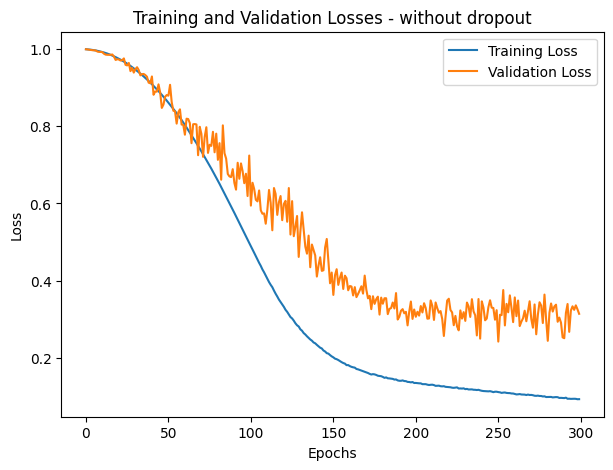

In [27]:
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses - without dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xticks(range(0, len(train_losses), 1))  # Specify tick locations every 5 epochs
plt.legend()
plt.show()

In [20]:
model.eval()

test_loss = 0.0
test_image = []
ground_truth = []
predicted_patches = []

model.to(device)

with torch.no_grad():
    for batch in test_loader:
        # moving data to device
        images = batch['ct_generated'].float().to(device)
        std_maps = batch['std_map'].float().to(device)
        
        images = images.unsqueeze(0)
        std_maps = std_maps.unsqueeze(0)

        y_pred = model(images)

        # calculating loss
        loss = average_relative_error(y_pred, std_maps)
        test_loss += loss.item() * images.size(0)
        y_pred = y_pred.unsqueeze(0)

        # appending data for visualization
        test_image.append(images.cpu().numpy())
        ground_truth.append(std_maps.cpu().numpy())
        predicted_patches.append(y_pred.cpu().numpy())

# calculating average test loss
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.2168


In [21]:
# visualizing prediction

test_image_array = np.array(test_image)
ground_truth_array = np.array(ground_truth)
predicted_patches_array = np.array(predicted_patches)

test_image_array = test_image_array.reshape(8,8,64,64)
ground_truth_array = ground_truth_array.reshape(8,8,64,64)
predicted_patches_array = predicted_patches_array.reshape(8,8,64,64)

test_image_final = np.concatenate([np.concatenate(row, axis=1) for row in test_image_array], axis=0)
ground_truth_final = np.concatenate([np.concatenate(row, axis=1) for row in ground_truth_array], axis=0)
predicted_patches_final = np.concatenate([np.concatenate(row, axis=1) for row in predicted_patches_array], axis=0)


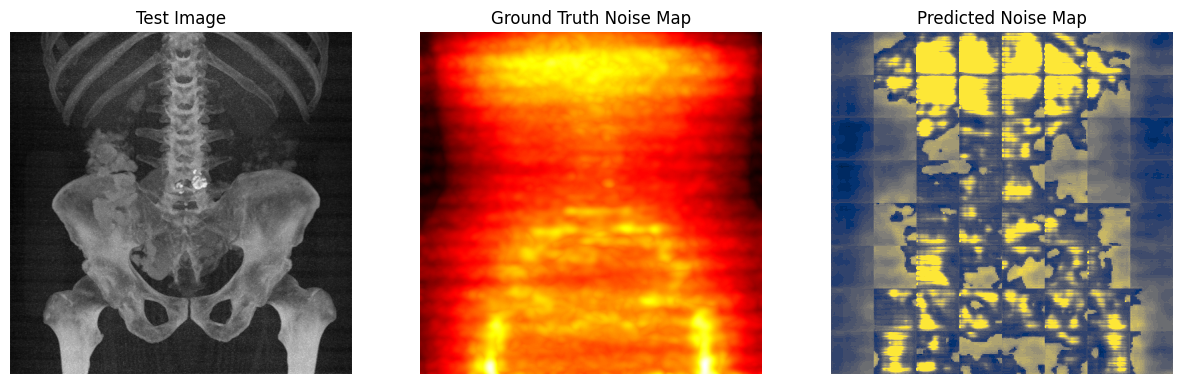

In [49]:
# Plot the test image
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(np.rot90(test_image_final), cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.rot90(ground_truth_final), cmap='hot')
plt.title('Ground Truth Noise Map')
plt.axis('off')

# Brightness factor (adjust as needed)
brightness_factor = 12.0

plt.subplot(133)
# Create a brighter version of the 'hot' colormap
cividis_brighter = plt.cm.cividis(np.linspace(0, brightness_factor, 256))
cividis_brighter = ListedColormap(cividis_brighter)

# Plot the image with the brighter colormap
plt.imshow(np.rot90(predicted_patches_final), cmap=viridis_brighter)
plt.title('Predicted Noise Map')
plt.axis('off')
plt.show()

## Section-6: RATUNet Training and Testing

In [308]:
class RatUNet(nn.Module):
    def __init__(self, block, num_features=64):
        super(RatUNet, self).__init__()
        self.inplanes = num_features
        
        self.conv = nn.Conv2d(1, num_features, kernel_size=3, stride=1, padding=1, bias=True)

        self.layer1 = self._make_layer(block, 64, 128, 3, stride=2)
        self.layer2 = self._make_layer(block, 128, 256, 3, stride=2)

        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.layer3 = self._make_layer(block, 256, 512, 4, stride=2)
        self.deconv2 = nn.ConvTranspose2d(512, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)

        self.layer4 = self._make_layer(block, 256, 256, 3)
        self.layer5 = self._make_layer(block, 128, 128, 3)
        self.layer6 = self._make_layer(block, 128, 128, 2)
        self.conv2 = nn.Sequential(nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=True),
                                   nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=True),
                                   nn.ReLU(inplace=True),
                                   )
        self.ca = SequentialPolarizedSelfAttention(128)
        self.lastconv = nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1, bias=True)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0.0, math.sqrt(1.0 / n))
                m.bias.data.zero_()

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        layers = []
        downsample = None
        self.inplanes = inplanes
        if stride != 1:
            downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, bias=True),
                    nn.AvgPool2d(kernel_size=2, stride=stride),
            )
#        if  stride == 1 and self.inplanes == 2*planes:
#            downsample = nn.Sequential(
#                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, bias=True),
#                #nn.BatchNorm2d(planes)
#            )
        
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        res = self.conv(x)

        res2 = self.layer1(res)
        res3 = self.layer2(res2)        
        out = self.layer3(res3)
        
        out = self.deconv1(out)               
        out = self.layer4(out)
        out = torch.cat((out, res3), dim=1) 

        out = self.deconv2(out)        
        out = self.layer5(out)
        out = torch.cat((out, res2), dim=1)
        
        out = self.deconv3(out)        
        out = self.layer6(out)
        out = torch.cat((out, res), dim=1)
        
        out = self.conv2(out)
        out = self.ca(out)
        out = self.lastconv(out)
        
        return x - out


In [309]:
class BasicBlock(nn.Module):
    expansion=1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride = stride, padding=1, bias=True)
        #self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.PReLU()#.LeakyReLU(0.2, inplace=True)# nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride = 1, padding=1, bias=True)
        #self.conv3 = nn.Conv2d(planes, planes, kernel_size=1, stride = 1, padding=0, bias=True)

        self.downsample = downsample
        #self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)        
        
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual      
        out = self.relu(out)

        return out


In [310]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=True),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=True))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class SequentialPolarizedSelfAttention(nn.Module):

    def __init__(self, channel=512):
        super().__init__()
        self.ch_wv=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.ch_wq=nn.Conv2d(channel,1,kernel_size=(1,1))
        self.softmax_channel=nn.Softmax(1)
        self.softmax_spatial=nn.Softmax(-1)
        self.ch_wz=nn.Conv2d(channel//2,channel,kernel_size=(1,1))
        self.ln=nn.LayerNorm(channel)
        self.sigmoid=nn.Sigmoid()
        self.sp_wv=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.sp_wq=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.agp=nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        b, c, h, w = x.size()

        #Channel-only Self-Attention
        channel_wv=self.ch_wv(x) #bs,c//2,h,w
        channel_wq=self.ch_wq(x) #bs,1,h,w
        channel_wv=channel_wv.reshape(b,c//2,-1) #bs,c//2,h*w
        channel_wq=channel_wq.reshape(b,-1,1) #bs,h*w,1
        channel_wq=self.softmax_channel(channel_wq)
        channel_wz=torch.matmul(channel_wv,channel_wq).unsqueeze(-1) #bs,c//2,1,1
        channel_weight=self.sigmoid(self.ch_wz(channel_wz).reshape(b,c,1).permute(0,2,1)).permute(0,2,1).reshape(b,c,1,1) #bs,c,1,1self.ln(
        channel_out=channel_weight*x

        #Spatial-only Self-Attention
        spatial_wv=self.sp_wv(channel_out) #bs,c//2,h,w
        spatial_wq=self.sp_wq(channel_out) #bs,c//2,h,w
        spatial_wq=self.agp(spatial_wq) #bs,c//2,1,1
        spatial_wv=spatial_wv.reshape(b,c//2,-1) #bs,c//2,h*w
        spatial_wq=spatial_wq.permute(0,2,3,1).reshape(b,1,c//2) #bs,1,c//2
        spatial_wq=self.softmax_spatial(spatial_wq)
        spatial_wz=torch.matmul(spatial_wq,spatial_wv) #bs,1,h*w
        spatial_weight=self.sigmoid(spatial_wz.reshape(b,1,h,w)) #bs,1,h,w
        spatial_out=spatial_weight*channel_out
        return spatial_out


In [311]:
# Model and optimizer initialization
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RatUNet(BasicBlock, 64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#criterion = nn.MSELoss()
#criterion = nn.L1Loss()
model_saving_path = '/projectnb/ec500kb/projects/Project6/RatUNet.pth'

# Train the model
total_step = len(train_loader)
num_epochs = 300
best_val_loss = float('inf')  # Initialize best validation loss for model saving

In [312]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)
        
        optimizer.zero_grad()
        y_pred = model(img)
        loss = average_relative_error(y_pred, std_map)
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            std_map = image['std_map'].float().to(device)

            y_pred = model(img)
            val_loss = average_relative_error(y_pred, std_map)
            #val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


  0%|          | 0/512 [00:01<?, ?it/s]


RuntimeError: Given transposed=1, weight of size [512, 128, 3, 3], expected input[1, 256, 32, 16] to have 512 channels, but got 256 channels instead

## Section-7: Uncertainty Estimation